# Scraping Video Research's Japanese TV rankings for animation

## Introduction

Every week, the Japanese company Video Research reports on ratings for the most-viewed TV programs of the week. These are broken down into several categories, one of which is animation. We will attempt to compile them, to analyze them for any insights of interest.

Video Research's website maintains archives of their weekly rankings going back to the start of 2015. They were posting them well before that, however, and the Internet Archive's Wayback Machine still has rankings going back to late 1996. Furthermore, since 2007, the website Anime News Network has translated the animation rankings into English and posted them for readers. All three of these sites will be of use to us.

Eventually, we will be downloading almost 30 years' worth of weekly rankings, plus the English translations for a majority of them, adding to over 2,000 web pages. We won't need to wait for one to finish loading before requesting another, so we'll want to use an asynchronous HTTP client like in `httpx`. Two of the three sites are rate-limited, so we'll use the `aiolimiter` library to keep a lid on things, keeping every request inside an `async with limiter` block.

ANN limits clients to 60 requests every 60 seconds; to make sure we have a bit of leeway, we'll specify our allotted time-per-request to allow only 59 requests a minute. The Wayback Machine's limit is much stricter, at 15 requests a minute. Video Research's site doesn't seem to have a rate limit, but to keep our code consistent, we'll use a limiter that allows 10 requests per second.

In [1]:
from httpx import AsyncClient
from aiolimiter import AsyncLimiter

ann_limiter = AsyncLimiter(max_rate=1, time_period=60/59)
minimal_limiter = AsyncLimiter(max_rate=1, time_period=0.1)
ia_limiter = AsyncLimiter(max_rate=1, time_period=4)

async def limit_get(client: AsyncClient, limiter: AsyncLimiter,
                    url: str) -> bytes:
    async with limiter:
        response = await client.get(url)
    response.raise_for_status()
    return response.content

We'll also want to implement a retry policy, so we'll wrap this in another function.

In [2]:
import asyncio
from httpx import HTTPStatusError, ConnectError

async def retry_get(client: AsyncClient, limiter: AsyncLimiter,
                    url: str, retry_delays=[0.1, 0.3, 0.8, 2.0, 4.0]) -> bytes:
    for delay in retry_delays + [None]:
        # Attempt each delay, then a final attempt
        try:
            return await limit_get(client, limiter, url)
        except (HTTPStatusError, ConnectError) as e:
            if delay is None:
                raise # Final attempt failed, propagate error
            await asyncio.sleep(delay) # Wait before retrying

Most of the time, we won't be using this directly. If we're running this analysis more than once, or retrying after running into an error partway, it'd be a waste to download the same ranking repeatedly. We'll store downloaded pages in a local cache when we're confident they won't be meaningfully modified later. Then we can check the cache before downloading a page.

The `dbm` module in Python's standard library provides an interface for a simple key-value store backed by a local database. This should be perfect for our needs; we can use the URL as the key and the page contents as the value. To save disk space, at the cost of a bit more CPU time, we'll also compress pages with the standard `zlib` module. (The Brotli compression algorithm is optimized for HTML, so it tends to have a better compression ratio, but zlib is quite good and compresses faster.)

In [3]:
import dbm
from zlib import compress, decompress

async def cache_get(client: AsyncClient, limiter: AsyncLimiter,
                    url: str, retry_delays=[0.1, 0.3, 0.8, 2.0, 4.0]) -> bytes:
    with dbm.open('cache', 'c') as db:
        if url in db:
            return decompress(db[url])
        else:
            page = await retry_get(client, limiter, url, retry_delays)
            db[url] = compress(page)
            return page

With these preliminaries observed, we turn to the contents of the pages we'll be retrieving.

## Individual ranking pages

First, we must know how to extract the data from any given page. Here, we will start with the URL for a ranking page, such as these:

https://www.animenewsnetwork.com/news/2024-12-21/japanese-animation-tv-ranking-december-9-15/.219307<br>
https://www.videor.co.jp/tvrating/2020/07/39602.html<br>
https://web.archive.org/web/20060912042426/http://www.videor.co.jp:80/data/ratedata/backnum/2002/vol15.htm

And we will store the ranking table in a Pandas DataFrame.

`pd.read_html()` reads the contents of a page and returns a list of DataFrames made from each `<table>` element. Reading the pages turns out to be a bit tricky, because not every page uses the now-dominant UTF-8 character encoding. Until 2013, Video Research mostly encoded pages with Shift JIS, which was designed specifically for Japanese, or its extension CP932. If UTF-8 doesn't work, then, we'll use CP932.

In [4]:
import io
import pandas as pd

# For future-proofing with Pandas 3.0.
pd.options.mode.copy_on_write = True

def get_tables_from_page(url: str, page: bytes):
    for encoding in ['utf-8', 'CP932']:
        try:
            return pd.read_html(io.BytesIO(page), encoding=encoding)
        except UnicodeDecodeError:
            continue

    raise UnicodeDecodeError(f"Unknown encoding on {url}")

async def get_tables_from_url(client: AsyncClient, limiter: AsyncLimiter,
                              url: str):
    page = await cache_get(client, limiter, url)
        
    # One particular page has a nasty encoding error in one instance of
    # 'ＴＢＳ' that keeps throwing off Pandas, so we'll correct it manually.
    if url.endswith("backnum/1999/vol46.htm"):
        page = page.replace(b'\x80s\x82a\x82r', b'\x82s\x82a\x82r')
    
    return get_tables_from_page(url, page)

Next, of course, we have to select the right DataFrame.

On Anime News Network, this is usually straightforward, as there's only one `<table>` element on the page. [One post in 2015](https://www.animenewsnetwork.com/news/2015-09-17/japan-animation-tv-ranking-september-7-13/.93067) includes a summary of ratings for the recent live-action Death Note drama along with the normal table; the one we want is the second there, so we can avoid requiring special behavior by simply instructing our function to take the last table from each page.

We will, however, require special behavior in another context. In the first year ANN published this column, there were several cases where two, three, or even ten weeks' worth of ratings were included in one post. We'll want them all. This should be as simple as a call to `pd.concat()`. We could check for the specific pieces, but all are known to be in 2007 or 2008, so we can just check for those years -- the single-table pages will work fine, since `pd.concat()` works with a single DataFrame as input.

Combining DataFrames from separate pages will pose a problem, though: Not all the information we need is present in a given table. The broadcast dates are listed with the month and day, but not the year. The year is clear in the original context, but we will be combining rankings from over a decade, so "May 5" won't be very useful.

A reader viewing the page in a web browser has only one way to infer the year for the dates in the ranking: the date the article was published. Thus, we will augment our DataFrame with that date. That should be enough for us to clean the data up later. We'll need a function to get the date from the URL and turn it into a Python `date` object.

One more thing: Until the 2020s, ANN's tables included an image for the anime being broadcast; these will come out as NaN in our DataFrame. Sometimes there'll also be tables with an overlooked blank row. We'll want to remove both of these with `DataFrame.dropna()`.

In [5]:
from datetime import date
import re

def ann_get_pub_date(url: str):
    date_string = re.search(r"/news/([-\d]+)/", url)[1]
    return date.fromisoformat(date_string)

async def ann_get_df_from_url(client: AsyncClient, url: str):
    dfs = await get_tables_from_url(client, ann_limiter, url)
    if ("news/2007" in url) or ("news/2008" in url):
        df = pd.concat(dfs, ignore_index=True)
    else:
        df = dfs[-1]
    
    df = df.dropna(axis='index', how='all')
    df = df.dropna(axis='columns', how='all')
    df['Publish Date'] = pd.to_datetime(ann_get_pub_date(url))
    
    return df

The Video Research data is easier in some ways and trickier than others. Each page contains exactly one week's rankings, for each category they report on. These categories remain consistent throughout the time period we're examining:

1. News
2. Education, Culture, Practical Use
3. Music
4. Drama
5. Anime (originally "Manga")
6. Movie
7. Sports
8. Other entertainment programs

Web design standards, however, have changed. Video Research's ranking pages have been redesigned multiple times, and it was once much more common to use `<table>` elements for document layout control than it is now. So sometimes, `pd.read_html()` produces extra DataFrames from these non-table `<table>`s. Through trial and error, it was determined just where the relevant DataFrame would be in the list based on that list's length. One report in 2016 did have an error -- the Education table was duplicated under the Music table -- so we'll adjust for that too.

As a smaller issue, it turns out Video Research did not always use proper `<th>` cells for the headings of its ranking tables. This means Pandas doesn't pick up on that first row as containing column names. It's a simple matter to detect and fix those cases.

Video Research's tables include the year in their date column, so no need to add anything there.

In [6]:
async def vr_get_df_from_url(client: AsyncClient, url: str):
    is_wayback = url.startswith("http://web.archive.org/")
    limiter = ia_limiter if is_wayback else minimal_limiter
    
    dfs = await get_tables_from_url(client, limiter, url)
    if len(dfs) == 8 or url.endswith("2016/09/1217.html"):
        # Rankings for 2008 and later
        df = dfs[-4]
    elif len(dfs) == 14:
        # Rankings for 1996 to 2003
        df = dfs[-6]
    elif len(dfs) == 12:
        # Rankings for 2004 to 2008
        df = dfs[-5]
    else:
        raise Exception(f"Unexpected number of tables on {url}")
    
    df = df.dropna(axis='index', how='all')
    
    if '番組名' not in df.columns: # Japanese for 'program name'
        df.columns = df.iloc[0]
        df = df.iloc[1:]
    
    return df

## Multiple ranking pages

Now we're ready to concatenate the ranking tables from separate weeks.

In [7]:
async def get_df_from_url(client: AsyncClient, url: str):
    if "animenewsnetwork.com" in url:
        return await ann_get_df_from_url(client, url)
    else:
        return await vr_get_df_from_url(client, url)

async def get_df_from_urls(client: AsyncClient, urls: list[str]):
    coroutines = [get_df_from_url(client, url) for url in urls]
    return pd.concat(await asyncio.gather(*coroutines), ignore_index=True)

Of course, to make use of this, we'll need the URLs for all the rankings. We already know what years we need data for from each site: 1996-2014 for the Wayback Machine, 2015-present for Video Research, and 2007-present for Anime News Network. So we can break the problem down into finding all URLs needed for a given year on a given site.

We'll consider this problem separately for each site.

### Anime News Network

ANN has archive pages where one can view links to all news pieces in a given month or year, each with the headline and the date and time published. We'll need every annual page back to 2007, plus a way to extract the links to the TV rankings. The scraping library `BeautifulSoup` is popular for these purposes, but it can be slow on large pages, and these archive pages are quite large. On average, each year's page is about 1.5 MB, linking to over 5,000 articles. Therefore, we'll use the XML parsing library `lxml` instead -- it's a little less flexible and convenient, but for our purposes it won't matter much.

We'll use our cache to save time and bandwidth, but only for old archive pages; the current year's will naturally add new articles we want regularly, so we'll keep checking that on ANN's servers. There may be an edge condition here to consider, if the scrape is being run in a different time zone from the timestamps on ANN articles. Conceivably, a scrape could be run on January 1 in one's own timezone, but December 31 in ANN's; the previous year's archive is cached, but just hours later, ANN uploads a new ranking while it's still December 31 their time. This article will be listed in the previous year's archive, but subsequent scrapes will only look at the cached archive and miss it. To be safe, we'll guarantee that the archive is "frozen" only if the year has been over for at least 24 hours.

Over the years, the format ANN's used for the titles of these articles has varied slightly, between the likes of "Japanese Anime TV Ranking", "Japanese Animation TV Ranking", "Japan's Animation TV Ranking". We'll use a regular expression that should capture them all.

In [8]:
from datetime import timedelta
from urllib.parse import urljoin
from lxml import html

def ann_is_archive_frozen(year: int):
    return year < (date.today() - timedelta(1)).year

async def ann_tv_rankings_for_year(client: AsyncClient, year: int) -> list[str]:
    ann_base = "https://www.animenewsnetwork.com"
    archive_url = f"{ann_base}/news/{year}"

    # We'll only use the cache if we're looking at old archive pages.
    get_fn = cache_get if ann_is_archive_frozen(year) else retry_get

    archive_page = await get_fn(client, ann_limiter, archive_url)
    archive_lxml = html.fromstring(archive_page)
    articles = archive_lxml.find_class("article-list")[0]

    return [
        urljoin(ann_base, a.attrib['href'])
        for a in articles.findall('.//li/a')
        if re.search(r"Anim[a-z]+ TV Ranking", a.text_content())
    ]

### Video Research

This one is mostly simpler. Video Research is not a general-purpose news site, and TV ratings have a dedicated section, with pages only used to hold links to the back entries. So the web pages are much smaller, and we don't need a regular expression to identify the links needed. Using `BeautifulSoup` becomes more economical with the smaller pages, but we already have `lxml` and know how to use it, so there's no need to add another dependency.

The edge condition for caching is trickier, though. Ratings are collected not by the year they were posted in, but the year of the week they cover. Video Research treats weeks as running from Monday to Sunday, publishes each week's report the following Thursday, and considers a week to be part of a given year if it *ends* in that year. For example, Week 53 of 2023 was December 25-December 31. Video Research posted its report on Thursday, January 4, 2024. If we scraped *any* time from January 1 to January 3, even if we were on Japan Standard Time, we would risk caching the 2023 listing before it's complete.

January 4 is the latest a year's final report can be published. If five days have passed since the year ended, we're in the clear.

In [9]:
def vr_is_archive_frozen(year: int):
    return year < (date.today() - timedelta(5)).year

async def vr_tv_rankings_for_year(client: AsyncClient, year: int) -> list[str]:
    vr_base = "https://www.videor.co.jp"
    dir_url = f"{vr_base}/tvrating/past_tvrating/backnumber/{year}/"

    # We'll only use the cache if we're looking at old archive pages.
    get_fn = cache_get if vr_is_archive_frozen(year) else retry_get

    dir_page = await get_fn(client, minimal_limiter, dir_url)
    dir_lxml = html.fromstring(dir_page)
    articles = dir_lxml.find_class("rating-backnumber")[0]

    return [
        urljoin(dir_url, a.attrib['href'])
        for a in articles.findall('.//li/a')
    ]

### Wayback Machine

No scraping this time -- we have a proper API for what we need. We'll query the same API the Internet Archive's own site uses to search for archived pages when a user enters the first part of a URL. Available documentation seems to be a bit spotty, but [this guide](https://archive.org/developers/wayback-cdx-server.html) gives the gist, even though the endpoint we'll be querying is different.

Before Video Research changed their site in 2017, their ranking pages' URLs followed a consistent schema, which will give us the prefix to supply for the Wayback Machine's search. We'll also supply some more query parameters to make our lives and theirs easier. `collapse=urlkey` will group together multiple snapshots for the same URL, of which we'll take the most recent. `filter=statuscode:200` will restrict to snapshots where the crawler received a "200 OK" status code. And `fl=original,endtimestamp` will restrict the fields returned to the only two we'll need to get the URL for each snapshot.

One oddity of this API is that it returns an array of equal-sized arrays, with the first containing headers, rather than the array-of-objects style that most JSON APIs use today. This may be a bandwidth-saving measure. For our purposes, an array of dictionaries will be more convenient.

In [10]:
import json
from typing import cast
from urllib.parse import urlencode

def dictify(table: list[list]):
    cols = cast(list[str], table[0])
    body = table[1:]
    return [
        {c:row[i] for i, c in enumerate(cols)}
        for row in body
    ]

async def ia_tv_rankings_for_year(client: AsyncClient, year: int):
    API_URL = "https://web.archive.org/web/timemap/json"

    query_params = {
        'url': f"http://www.videor.co.jp/data/ratedata/backnum/{year}/vol",
        'matchType': "prefix",
        'collapse': "urlkey",
        'filter': "statuscode:200",
        'fl': "original,endtimestamp",
    }

    full_url = f"{API_URL}?{urlencode(query_params)}"

    dict_results = dictify(
        json.loads(await cache_get(client, ia_limiter, full_url))
    )

    return [
        f"https://web.archive.org/web/{d['endtimestamp']}/{d['original']}"
        for d in dict_results
    ]

That settles the matter of URLs for each year for each site. Now we need functions to do this for every year, and combine the URLs we need into one listing for Video Research and one for ANN.

In [11]:
async def vr_all_ranking_urls(client: AsyncClient):
    current_year = date.today().year

    vr_year_coros = [
        vr_tv_rankings_for_year(client, y)
        for y in range(current_year, 2014, -1)
    ]
    vr_year_coros.extend([
        ia_tv_rankings_for_year(client, y)
        for y in range(2014, 1995, -1)
    ])

    return [url for l in await asyncio.gather(*vr_year_coros) for url in l]

async def ann_all_ranking_urls(client: AsyncClient):
    current_year = date.today().year
    
    archive_coros = [
        ann_tv_rankings_for_year(client, y)
        for y in range(current_year, 2006, -1)
    ]

    return [url for l in await asyncio.gather(*archive_coros) for url in l]

We do have some duplicates to remove from these listings. Two cases were found on Video Research's site of one week having two ranking pages linked, in 2017 and 2018; similarly, one ranking article was accidentally double-posted on ANN in 2024. After verifying that each pair is identical, we can arbitrarily select one of each to discard.

In [12]:
async def confirm_duplicates(client: AsyncClient, url1: str, url2: str):
    df1 = await get_df_from_url(client, url1)
    df2 = await get_df_from_url(client, url2)
    if (df1 == df2).all(axis=None):
        print("DataFrames are duplicates.")
    else:
        print("DataFrames are not duplicates.")

vr_base = "https://www.videor.co.jp/tvrating"
ann_base = ("https://www.animenewsnetwork.com/news/2024-03-09/"
            "japanese-animation-tv-ranking-february-26-march-3")

dupes = [(
    f"{vr_base}/2018/04/9682.html",
    f"{vr_base}/2018/04/9687.html",
), (
    f"{vr_base}/2017/10/6087.html",
    f"{vr_base}/2017/10/6107.html",
), (
    f"{ann_base}/.208436",
    f"{ann_base}/.208545",
)]

async with AsyncClient(timeout=None) as client:
    for a, b in dupes:
        await confirm_duplicates(client, a, b)

DataFrames are duplicates.
DataFrames are duplicates.
DataFrames are duplicates.


In [13]:
def dedup_urls(urls: list[str]):
    to_remove = [a for _, a in dupes]
    return [u for u in urls if u not in to_remove]

All we need to get started now is the client.

In [14]:
def new_client():
    github_url = "https://github.com/ShayeHorwitz/anime_broadcast_ratings/"
    v = "2.0"
    return AsyncClient(timeout=None, headers={
        "Accept-Encoding": "gzip",
        "User-Agent": f"anime_broadcast_ratings/{v} ({github_url})",
    })

def report_percent_cached(urls: list[str]):
    with dbm.open('cache', 'c') as db:
        cached = len([u for u in urls if u in db])
    ratio = cached / len(urls)
    print(f"Scrape halted {ratio:.1%} of the way to completion. Keep trying.")


async def try_get_df_from_urls(client: AsyncClient, urls: list[str]):
    try:
        return await get_df_from_urls(client, urls)
    except:
        report_percent_cached(urls)
        raise


async def vr_get_full_df():
    async with new_client() as client:
        urls = dedup_urls(await vr_all_ranking_urls(client))
        return await try_get_df_from_urls(client, urls)


async def ann_get_full_df():
    async with new_client() as client:
        urls = dedup_urls(await ann_all_ranking_urls(client))
        return await try_get_df_from_urls(client, urls)

If you're running these on your own machine, they may take several tries due to server errors, but even failed attempts should further populate the cache and bring you closer to success. I've added an error-reporting function so you can tell how far along you are in the event of failure.

In [15]:
vr_raw_df = await vr_get_full_df()
vr_raw_df

,番組名,放送局,放送日,放送開始-分数,番組平均 個人視聴率（％）※,番組平均 世帯視聴率（％）,番組平均 世帯視聴率(%),番組平均 個人視聴率(%)※,番組平均 個人視聴率(%) ※,番組平均 世帯視聴率(％),放送開始 -分数,番組平均 世帯視聴率(%),視聴率(%)
0,サザエさん,フジテレビ,25/3/09(日),18:30-30,5.8,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ちびまる子ちゃん,フジテレビ,25/3/09(日),18:00-30,3.9,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,名探偵コナン,日本テレビ,25/3/08(土),18:00-30,3.8,6.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ドラえもん,テレビ朝日,25/3/08(土),17:00-30,2.2,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ＦＲＩＤＡＹ ＡＮＩＭＥ ＮＩＧＨＴ薬屋のひとりごと,日本テレビ,25/3/07(金),23:30-30,2.0,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15053,花より男子,テレビ朝日,'96 12/29(日),NaN,NaN,NaN,NaN,NaN,NaN,NaN,08:30-30,8.0,NaN
15054,きこちゃんすまいる,ＴＢＳ,'96 12/28(土),NaN,NaN,NaN,NaN,NaN,NaN,NaN,17:00-30,7.1,NaN
15055,アニメ・あずきちゃん,ＮＨＫ教育,'96 12/28(土),NaN,NaN,NaN,NaN,NaN,NaN,NaN,18:25-25,6.6,NaN
15056,逮捕しちゃうぞ,ＴＢＳ,'96 12/28(土),NaN,NaN,NaN,NaN,NaN,NaN,NaN,17:30-30,5.7,NaN


In [16]:
ann_raw_df = await ann_get_full_df()
ann_raw_df

,Title,Station,Date,Time,Length,Average Household Rating,Publish Date
0,Sazae-san,Fuji TV,March 2 (Sun),18:30,30 min.,7.8,2025-03-09
1,Detective Conan,NTV,March 1 (Sat),18:00,30 min.,6.5,2025-03-09
2,Chibi Maruko-chan,Fuji TV,March 2 (Sun),18:00,30 min.,5.8,2025-03-09
3,The Apothecary Diaries,NTV,February 28 (Fri),23:00,30 min.,3.8,2025-03-09
4,Blue Miburo,NTV,March 1 (Sat),17:30,30 min.,3.6,2025-03-09
...,...,...,...,...,...,...,...
9407,Kakashi's Team Advances! Naruto: Shippuuden Sp...,TV Tokyo,April 12 (Thurs),19:59,55 min.,5.3,2007-04-19
9408,Pururun! Shizuku-chan,TV Tokyo,April 14 (Sat),09:30,30 min.,5.3,2007-04-19
9409,Bleach,TV Tokyo,April 11 (Wed),19:26,29 min.,4.9,2007-04-19
9410,Oha Coliseum,TV Tokyo,April 14 (Sat),08:30,30 min.,4.9,2007-04-19


And now to save our DataFrames as CSVs.

In [17]:
from datetime import datetime
from pathlib import Path

def timestamped_csv(title: str, df: pd.DataFrame):
    Path("raw").mkdir(exist_ok=True)
    df.to_csv(f"{title}_{datetime.now():%Y%m%d%H%M%S}.csv", index=False)

timestamped_csv("raw/vr_tv_rankings", vr_raw_df)
timestamped_csv("raw/ann_tv_rankings", ann_raw_df)

We could also use a more sophisticated format like [Feather](https://arrow.apache.org/docs/python/feather.html), but both of these combined are currently less than 2 MB as CSVs, so that format works fine for our purposes. If we want to close our notebook and jump back in at this point later, with a previously scraped copy of the data, this function will prove handy:

In [18]:
import glob

def quickload_csv(title: str) -> pd.DataFrame:
    return pd.read_csv(max(glob.glob(f"{title}_*.csv")))

# Loads the most recent CSV.
# Example usage:
# vr_raw_df = quickload_csv("raw/vr_tv_rankings")

# Post-download processing

We are now tasked with cleaning and unifying two datasets in different languages from three websites. This is a daunting task, and will prove quite lengthy; if it doesn't interest you, I encourage you to use your browser's search function to skip to the section headed "Insights".

It's good data analysis practice to make a copy of your raw data before cleanup.

In [19]:
vr_cleaned_df = vr_raw_df.copy()

In [20]:
ann_cleaned_df = ann_raw_df.copy()

First, we'll take a look at the shape of each DataFrame.

In [21]:
vr_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15058 entries, 0 to 15057
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   番組名                15058 non-null  object
 1   放送局                15058 non-null  object
 2   放送日                15058 non-null  object
 3   放送開始-分数            8665 non-null   object
 4   番組平均  個人視聴率（％）※    1618 non-null   object
 5   番組平均  世帯視聴率（％）     1618 non-null   object
 6   番組平均  世帯視聴率(%)     3867 non-null   object
 7   番組平均  個人視聴率(%)※    1060 non-null   object
 8   番組平均  個人視聴率(%)  ※  20 non-null     object
 9   番組平均  世帯視聴率(％)     3180 non-null   object
 10  放送開始 -分数           6393 non-null   object
 11  番組平均 世帯視聴率(%)      6363 non-null   object
 12  視聴率(%)             30 non-null     object
dtypes: object(13)
memory usage: 1.5+ MB


In [22]:
ann_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9412 entries, 0 to 9411
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Title                     9412 non-null   object        
 1   Station                   9412 non-null   object        
 2   Date                      9412 non-null   object        
 3   Time                      9412 non-null   object        
 4   Length                    9412 non-null   object        
 5   Average Household Rating  9412 non-null   float64       
 6   Publish Date              9412 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 514.8+ KB


One of the most obvious differences between the two DataFrames is how many more columns Video Research's has, with a great deal of NaN values. It's also clear that this is largely due to the columns having slight differences in their headings from one page to another -- differences in whitespace, for instance, or [halfwidth vs. fullwidth](https://en.wikipedia.org/wiki/Halfwidth_and_fullwidth_forms) Latin characters. If we group these together appropriately, we can expect any given row of the DataFrame to have NaN in all but one column of each group.

In [23]:
time_length_cols = [c for c in vr_cleaned_df.columns if '放送開始' in c]
household_rating_cols = [c for c in vr_cleaned_df.columns
                         if '視聴率' in c and '個人' not in c]
individual_rating_cols = [c for c in vr_cleaned_df.columns if '個人' in c]

In [24]:
vr_cleaned_df[time_length_cols].isna().value_counts()

放送開始-分数  放送開始 -分数
False    True        8665
True     False       6393
Name: count, dtype: int64

In [25]:
vr_cleaned_df[household_rating_cols].isna().value_counts()

番組平均  世帯視聴率（％）  番組平均  世帯視聴率(%)  番組平均  世帯視聴率(％)  番組平均 世帯視聴率(%)  視聴率(%)
True            True            True            False          True      6363
                False           True            True           True      3867
                True            False           True           True      3180
False           True            True            True           True      1618
True            True            True            True           False       30
Name: count, dtype: int64

In [26]:
vr_cleaned_df[individual_rating_cols].isna().value_counts()

番組平均  個人視聴率（％）※  番組平均  個人視聴率(%)※  番組平均  個人視聴率(%)  ※
True             True             True                 12360
False            True             True                  1618
True             False            True                  1060
                 True             False                   20
Name: count, dtype: int64

The expected pattern holds with all but the ratings for what proportion of individual viewers were watching -- for many rows, that data is not available in any column. This is because Video Research only started reporting this data in 2020; previously, they had only reported viewership rates for households.

As of this writing, Anime News Network still does not report the figures for individuals. This complicates their reporting in a subtle way, because Video Research presently ranks broadcasts by individual ratings, with the household ratings only providing additional information. ANN re-sorts these rankings by household rating before publication. For example, for the week of 17-23 February 2025, Video Research [places](https://www.videor.co.jp/tvrating/2025/02/88840.html#block05) Chibi Maruko-chan, with an individual rating of 3.9 and a household rating of 5.7, above Detective Conan, with an individual rating of 3.8 and a household rating of 6.3. ANN [reverses these](https://www.animenewsnetwork.com/news/2025-03-01/japanese-animation-tv-ranking-february-17-23/.221760), putting Detective Conan first. It's likely that on any number of occasions, a broadcast with one of the week's top 10 household ratings didn't have one of the top 10 individual ratings, meaning Video Research didn't list it at all -- and making ANN's ranking, presented as a ranking of the top household ratings, incomplete.

Returning to the problem of duplicate columns, it's a simple enough task to consolidate them. In the process, we'll rename the merged columns to match the ones used in ANN's translations; this is expected to be easier for most readers here as well. While we're at it, we'll rename the remaining columns as well.

In [27]:
def combine_columns(df: pd.DataFrame, old_cols: list[str], new_col: str):
    new_df = df.copy()
    new_series = new_df[old_cols[0]].copy()
    for c in old_cols[1:]:
        new_series = new_series.combine_first(new_df[c])
    new_df = new_df.drop(columns=old_cols)
    new_df[new_col] = new_series
    return new_df

vr_cleaned_df = combine_columns(vr_cleaned_df, time_length_cols,
                                "Time and Length")
vr_cleaned_df = combine_columns(vr_cleaned_df, household_rating_cols,
                                "Average Household Rating")
vr_cleaned_df = combine_columns(vr_cleaned_df, individual_rating_cols,
                                "Average Individual Rating")
vr_cleaned_df = vr_cleaned_df.rename(columns={
    "番組名": "Title",
    "放送局": "Station",
    "放送日": "Date",
})

vr_cleaned_df

,Title,Station,Date,Time and Length,Average Household Rating,Average Individual Rating
0,サザエさん,フジテレビ,25/3/09(日),18:30-30,8.1,5.8
1,ちびまる子ちゃん,フジテレビ,25/3/09(日),18:00-30,5.5,3.9
2,名探偵コナン,日本テレビ,25/3/08(土),18:00-30,6.4,3.8
3,ドラえもん,テレビ朝日,25/3/08(土),17:00-30,3.7,2.2
4,ＦＲＩＤＡＹ ＡＮＩＭＥ ＮＩＧＨＴ薬屋のひとりごと,日本テレビ,25/3/07(金),23:30-30,3.8,2.0
...,...,...,...,...,...,...
15053,花より男子,テレビ朝日,'96 12/29(日),08:30-30,8.0,NaN
15054,きこちゃんすまいる,ＴＢＳ,'96 12/28(土),17:00-30,7.1,NaN
15055,アニメ・あずきちゃん,ＮＨＫ教育,'96 12/28(土),18:25-25,6.6,NaN
15056,逮捕しちゃうぞ,ＴＢＳ,'96 12/28(土),17:30-30,5.7,NaN


In [28]:
vr_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15058 entries, 0 to 15057
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Title                      15058 non-null  object
 1   Station                    15058 non-null  object
 2   Date                       15058 non-null  object
 3   Time and Length            15058 non-null  object
 4   Average Household Rating   15058 non-null  object
 5   Average Individual Rating  2698 non-null   object
dtypes: object(6)
memory usage: 706.0+ KB


Our columns have been pulled together, and we can clearly see which ones correspond to which on the two DataFrames. Let's process them further, column by column.

## Station

Let's start by looking at this column on the ANN DataFrame.

In [29]:
ann_cleaned_df['Station'].value_counts()

Station
Fuji TV        3382
TV Asahi       2241
NTV            1662
TV Tokyo       1059
NHK-E           892
TBS             104
NHK              41
NHK-G            23
NHK General       6
TV-TOKYO          1
Nippon TV         1
Name: count, dtype: int64

As you can see, there are a few inconsistencies in the names used for the Kanto-region TV stations, which we'll normalize to ANN's current standard. This is also a good case for use of a categorical data type, since there will only be seven possible string values when we're done.

In [30]:
ann_cleaned_df['Station'] = ann_cleaned_df['Station'].replace({
    'NHK-G':       'NHK',
    'NHK General': 'NHK',
    'TV-TOKYO':    'TV Tokyo',
    'Nippon TV':   'NTV',
}).astype('category')

ann_cleaned_df['Station'].value_counts()

Station
Fuji TV     3382
TV Asahi    2241
NTV         1663
TV Tokyo    1060
NHK-E        892
TBS          104
NHK           70
Name: count, dtype: int64

All seven national terrestrial networks, two public and five commercial, are represented. TBS has the fewest appearances of the commercial networks, though it does have some standout franchises like Gundam (from 2002 to 2023) and Jujutsu Kaisen. Of note, independent UHF stations like [Tokyo MX](https://en.wikipedia.org/wiki/Tokyo_MX) are completely absent. This could be because none of their anime have ever had enough live viewers, though it may also be that Video Research undercounts viewership rates for these stations because they have less signal power, and therefore reach fewer viewers.

For example, the anime Oshi no Ko and Mobile Suit Gundam: The Witch from Mercury were both popular in the spring of 2023. But everyone in Kanto who watched The Witch from Mercury with a TV antenna did so on TBS, while Oshi no Ko's Kanto viewers would've watched it on Tokyo MX in Tokyo, [TV Kanagawa](https://en.wikipedia.org/wiki/Television_Kanagawa) in Yokohama, [Gunma TV](https://en.wikipedia.org/wiki/Gunma_Television) in Maebashi, and so on. If Video Research counts viewers of those broadcasts separately, the viewership numbers for Oshi no Ko would be fragmented. This could explain why Oshi no Ko never charted in this time and The Witch from Mercury did, even though Google Trends [suggests](https://trends.google.com/trends/explore?date=2023-01-01%202023-12-31&geo=JP&q=%E6%8E%A8%E3%81%97%E3%81%AE%E5%AD%90,%E6%B0%B4%E6%98%9F%E3%81%AE%E9%AD%94%E5%A5%B3,%E9%AC%BC%E6%BB%85%E3%81%AE%E5%88%83,%E3%82%AC%E3%83%B3%E3%83%80%E3%83%A0&hl=en-US) there was more interest in Oshi no Ko than The Witch from Mercury at the time, or even the overwhelmingly popular Demon Slayer: Kimetsu no Yaiba.

Setting that question aside, we turn to the corresponding Video Research column.

In [31]:
vr_cleaned_df['Station'].value_counts()

Station
フジテレビ           5592
テレビ朝日           3623
日本テレビ           2608
テレビ東京           1938
ＮＨＫＥテレ           820
ＴＢＳ              166
ＮＨＫ総合            146
ＮＨＫ教育            124
'97　3/23(日)        4
（フジテレビ             4
'97 4/06(日)        4
（テレビ朝日             3
'97/ 4/20(日)       3
'97/ 4/14(月)       2
'97/ 4/16(水)       2
'97 4/04(金)        2
'97　3/22(土)        2
'97　3/21(金)        2
（日本テレビ             2
'97　3/19(水)        1
'97　3/17(月)        1
'97 4/03(木)        1
'97 3/31(月)        1
'97 4/05(土)        1
'97 4/01(火)        1
フジテ′ビ              1
（テレビ東京             1
'97/ 4/18(金)       1
'97/ 4/15(火)       1
'97/ 4/19(土)       1
Name: count, dtype: int64

A bit more than a few inconsistencies, this time! It's easy enough to tell what the normal values are. Let's use a list of those to see what the abnormal values look like.

In [32]:
standard_stations = [
    'フジテレビ',
    'テレビ朝日',
    '日本テレビ',
    'テレビ東京',
    'ＮＨＫＥテレ',
    'ＴＢＳ',
    'ＮＨＫ総合',
    'ＮＨＫ教育',
]
vr_cleaned_df.loc[
    ~vr_cleaned_df['Station'].isin(standard_stations)
]

,Title,Station,Date,Time and Length,Average Household Rating,Average Individual Rating
13619,サザエさん,（フジテレビ,'99 7/4(日),18:30-30,20.0,NaN
13620,名探偵コナン,（日本テレビ,'99 6/28(月),19:30-30,17.2,NaN
13621,ＧＴＯ,（フジテレビ,'99 6/30(水),19:00-60,16.9,NaN
13622,ドラえもん,（テレビ朝日,'99 7/2(金),19:00-30,14.7,NaN
13623,クレヨンしんちゃん,（テレビ朝日,'99 7/2(金),19:30-30,14.3,NaN
13624,ポケットモンスター,（テレビ東京,'99 7/1(木),19:00-30,13.5,NaN
13625,金田一少年の事件簿,（日本テレビ,'99 6/28(月),19:00-30,13.1,NaN
13626,おジャ魔女どれみ,（テレビ朝日,'99 7/4(日),8:30-30,13.0,NaN
13627,デジモンアドベンチャー,（フジテレビ,'99 7/4(日),9:00-30,12.4,NaN
13628,こちら葛飾区亀有公園前派出所,（フジテレビ,'99 7/4(日),19:00-30,11.9,NaN


One ranking in 1999 prefaces all stations with an open parenthesis; three in 1997 switch the `Station` and `Date` columns. They're easy enough to target and fix.

In [33]:
errant_parenthesis = vr_cleaned_df['Station'].str.startswith("（")

# Chop off that stray parenthesis.
vr_cleaned_df.loc[errant_parenthesis, 'Station'] = \
    vr_cleaned_df.loc[errant_parenthesis, 'Station'].str.slice(1)

columns_swapped = vr_cleaned_df['Station'].str.startswith("'97")

# Copy the values for the swapped columns into new Series...
should_be_station = vr_cleaned_df.loc[columns_swapped, 'Date'].copy()
should_be_date = vr_cleaned_df.loc[columns_swapped, 'Station'].copy()

# ...and put them in their rightful places.
vr_cleaned_df.loc[columns_swapped, 'Station'] = should_be_station
vr_cleaned_df.loc[columns_swapped, 'Date'] = should_be_date

vr_cleaned_df['Station'].value_counts()

Station
フジテレビ     5612
テレビ朝日     3634
日本テレビ     2614
テレビ東京     1941
ＮＨＫＥテレ     820
ＴＢＳ        166
ＮＨＫ総合      146
ＮＨＫ教育      124
フジテ′ビ        1
Name: count, dtype: int64

You may have noticed there's also one row we didn't address, with a simple typo in Fuji TV's name. We don't need to get fancy for that one, though. We're going to replace the station names with their English names now, so we'll just include it with the others.

In [34]:
vr_cleaned_df['Station'] = vr_cleaned_df['Station'].replace({
    'ＮＨＫ総合': 'NHK', # Channel 1
    'ＮＨＫＥテレ': 'NHK-E', # Channel 2
    'ＮＨＫ教育': 'NHK-E', # Channel 2, alternate name
    '日本テレビ': 'NTV', # Channel 4
    'テレビ朝日': 'TV Asahi', # Channel 5
    'ＴＢＳ': 'TBS', # Channel 6
    'テレビ東京': 'TV Tokyo', # Channel 7
    'フジテレビ': 'Fuji TV', # Channel 8
    'フジテ′ビ': 'Fuji TV', # Typo in one row
}).astype('category')

vr_cleaned_df['Station'].value_counts()

Station
Fuji TV     5613
TV Asahi    3634
NTV         2614
TV Tokyo    1941
NHK-E        944
TBS          166
NHK          146
Name: count, dtype: int64

## Average Household Rating

We should just need to convert these from strings to floats. Let's make sure everything looks right. Video Research first:

In [35]:
vr_normal_household_rating = \
    vr_cleaned_df['Average Household Rating'].str.fullmatch(r"(\d+\.\d)")

try:
    vr_cleaned_df.loc[~vr_normal_household_rating]
except Exception as e:
    print(f"{type(e).__name__}: {e}")
    # Normally this is poor style, but here it's good for demonstration without
    # interrupting the notebook.

TypeError: bad operand type for unary ~: 'float'


No, I don't think everything looks right. We seem to have found ourselves with a mix of strings and floats in this column:

In [36]:
vr_cleaned_df['Average Household Rating'].apply(type).value_counts()

Average Household Rating
<class 'str'>      12932
<class 'float'>     2126
Name: count, dtype: int64

Digging deeper, the floats start at the beginning of 2011, corresponding to one of the changes in Video Research's website design, and continue to the end of the Wayback Machine pages. It's not clear what made the difference between `pd.read_html()` recognizing the ratings as floats or not, but it's easily enough fixed.

In [37]:
str_ratings = vr_cleaned_df['Average Household Rating'].astype(str)
vr_normal_household_rating = str_ratings.str.fullmatch(r"(\d+\.\d)")

vr_cleaned_df.loc[~vr_normal_household_rating]

,Title,Station,Date,Time and Length,Average Household Rating,Average Individual Rating
11901,サザエさん,Fuji TV,'02/4/14(日),18:30 - 30,21.0%,NaN
11902,名探偵コナン,NTV,'02/4/8(月),19:30 - 30,17.9%,NaN
11903,こちら葛飾区亀有公園前派出所,Fuji TV,'02/4/14(日),19:00 - 30,15.5%,NaN
11904,ワンピース,Fuji TV,'02/4/14(日),19:30 - 28,14.3%,NaN
11905,犬夜叉,NTV,'02/4/8(月),19:00 - 30,13.4%,NaN
11906,ちびまる子ちゃん,Fuji TV,'02/4/14(日),18:00 - 30,12.8%,NaN
11907,テニスの王子様スペシャル,TV Tokyo,'02/4/10(水),19:01 - 52,9.5%,NaN
11908,デジモンフロンティア,Fuji TV,'02/4/14(日),9:00 - 30,9.5%,NaN
11909,おジャ魔女どれみドッカ〜ン！,TV Asahi,'02/4/14(日),8:30 - 30,9.1%,NaN
11910,ポケットモンスター,TV Tokyo,'02/4/11(木),19:00 - 30,8.9%,NaN


One listing in 1998 and another in 1999 omit the decimal if it's a zero -- reading "15" instead of "15.0", for instance. Another listing in 2002 includes a percent sign, which the rest omit. Accounting for these should be relatively easy.

In [38]:
rating_regex = r"([\d\.]+)%?"

float_ratings = str_ratings.str.extract(rating_regex)[0].astype(float)
vr_cleaned_df['Average Household Rating'] = float_ratings

Our ANN data was already in float format, so it doesn't need adjustment:

In [39]:
ann_cleaned_df['Average Household Rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9412 entries, 0 to 9411
Series name: Average Household Rating
Non-Null Count  Dtype  
--------------  -----  
9412 non-null   float64
dtypes: float64(1)
memory usage: 73.7 KB


Let's check to see that the values are what we'd expect, too.

In [40]:
ann_cleaned_df['Average Household Rating'].describe()

count    9412.000000
mean        6.679367
std         3.878301
min         0.600000
25%         3.700000
50%         5.800000
75%         8.800000
max        85.000000
Name: Average Household Rating, dtype: float64

We have a clear outlier; it's very unlikely an anime broadcast gained an 85% viewership rating in the 21st century. Let's look closer.

In [41]:
ann_cleaned_df.sort_values(by='Average Household Rating').tail()

,Title,Station,Date,Time,Length,Average Household Rating,Publish Date
7629,Sazae-san,Fuji TV,November 28 (Sun),18:30,30 min.,24.0,2010-12-05
7539,Sazae-san,Fuji TV,January 30 (Sun),18:30,30 min.,24.2,2011-02-06
7560,Sazae-san,Fuji TV,January 16 (Sun),18:30,30 min.,24.3,2011-01-23
7681,Sazae-san,Fuji TV,October 24 (Sun),18:30,30 min.,24.7,2010-11-08
2809,Chibi Maruko-chan,Fuji TV,January 5 (Sun),18:00,30 min.,85.0,2020-01-17


In [42]:
vr_cleaned_df.sort_values(by='Average Household Rating').tail()

,Title,Station,Date,Time and Length,Average Household Rating,Average Individual Rating
12912,サザエさん,Fuji TV,'00/3/12(日),18:30 - 30,27.4,NaN
13438,サザエさん,Fuji TV,'99 3/7(日),18:30-30,27.4,NaN
13931,サザエさん,Fuji TV,'99 2/21(日),18:30-30,28.0,NaN
13408,サザエさん,Fuji TV,'00 2/20(日),18:30 - 30,28.1,NaN
13921,サザエさん,Fuji TV,'99 2/14(日),18:30-30,28.2,NaN


Anime News Network's archives can also be accessed by the day. [Pasting in the relevant date](https://animenewsnetwork.com/news/2020-01-17), we can quickly find our ranking, where we see the problem: Chibi Maruko-chan's 8.5 rating was mistyped with a comma. Let's correct that now.

In [43]:
marukochan85 = ann_cleaned_df['Average Household Rating'] == 85

ann_cleaned_df.loc[marukochan85, 'Average Household Rating'] = 8.5
ann_cleaned_df.loc[marukochan85]

,Title,Station,Date,Time,Length,Average Household Rating,Publish Date
2809,Chibi Maruko-chan,Fuji TV,January 5 (Sun),18:00,30 min.,8.5,2020-01-17


That's our only real outlier; we can see that the Sazae-san ratings are quite plausible for that period. We'll give the statistical distributions for each series a once-over just to be safe.

In [44]:
ann_cleaned_df['Average Household Rating'].describe()

count    9412.000000
mean        6.671239
std         3.793376
min         0.600000
25%         3.700000
50%         5.800000
75%         8.800000
max        24.700000
Name: Average Household Rating, dtype: float64

In [45]:
vr_cleaned_df['Average Household Rating'].describe()

count    15058.000000
mean         8.882235
std          4.955342
min          0.600000
25%          4.900000
50%          8.100000
75%         12.000000
max         28.200000
Name: Average Household Rating, dtype: float64

While we're at it, let's check out Video Research's individual ratings column.

In [46]:
vr_cleaned_df['Average Individual Rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 15058 entries, 0 to 15057
Series name: Average Individual Rating
Non-Null Count  Dtype 
--------------  ----- 
2698 non-null   object
dtypes: object(1)
memory usage: 117.8+ KB


Its dtype is "object", but most of its values are NaN, meaning this is probably a mixture of strings and floats:

In [47]:
vr_cleaned_df['Average Individual Rating'].apply(type).value_counts()

Average Individual Rating
<class 'float'>    12360
<class 'str'>       2698
Name: count, dtype: int64

And it looks like all the non-null values are strings. Let's see what the whole column looks if we stringify it:

In [48]:
vr_air_s = vr_cleaned_df['Average Individual Rating'].astype(str)
vr_air_s.value_counts().head(10)

Average Individual Rating
nan    12360
1.7      165
1.8      165
1.9      160
1.5      147
1.6      147
2.0      146
1.4      145
2.1      135
2.2      105
Name: count, dtype: int64

Are the non-null values all what we'd expect?

In [49]:
vr_air_s.str.fullmatch(r"nan|([\d\.]+)").all()

np.True_

Yes, they are. Let's cast the column to float.

In [50]:
vr_cleaned_df['Average Individual Rating'] = vr_air_s.astype(float)
vr_cleaned_df['Average Individual Rating'].value_counts().head(10)

Average Individual Rating
1.7    165
1.8    165
1.9    160
1.5    147
1.6    147
2.0    146
1.4    145
2.1    135
2.2    105
1.3    102
Name: count, dtype: int64

## Time and Length

This is presently one column in the Video Research DataFrame, but two columns in the ANN DataFrame. Bringing them in line will be tricky.

Let's start with Video Research. You will have noticed that the `Time and Length` column generally follows a standard format, though there turn out to be some slight variations. Through trial and error, a regular expression can be constructed that matches nearly all values and extracts the parts relevant to us. It breaks down as follows:

* `(\d+:\d+)`: One or more digits, a colon, then one or more digits. **Extract** to use as the broadcast time.
* `\s?-\s?`: A hyphen, optionally with whitespace on either side.
* `(\d+)`: One or more digits. **Extract** to use as the broadcast length in minutes.
* `(?:分間)?`: Optionally, the Japanese word "bunkan" (minutes). Used only for three weeks in 2020. A non-capturing group; will not be extracted.

As you may have guessed from "nearly all", though, there's still one anomaly that doesn't conform to this format, though.

In [51]:
time_length_regex = r"(\d+:\d+)\s?-\s?(\d+)(分間)?"
normal_time_length = \
    vr_cleaned_df['Time and Length'].str.fullmatch(time_length_regex)

vr_cleaned_df.loc[~normal_time_length]

,Title,Station,Date,Time and Length,Average Household Rating,Average Individual Rating
7088,アニメメジャー５,NHK-E,'11/01/01(土),9:14 - 24 11:16 - 25,2.0,NaN
7089,アニメメジャー５,NHK-E,'11/01/01(土),8:00 - 25 8:49 - 25 9:38 - 25 10:03 - 24 1...,1.9,NaN


On the morning of New Year's Day 2011, NHK Educational TV seems to have broadcast several episodes of the baseball anime Major. Video Research would normally list episodes separately, but this time they grouped them together. It'll take several steps, but we can tease them apart again.

In [52]:
major_marathon = vr_cleaned_df.loc[~normal_time_length].copy()

# It turns out we only need to split on ordinary space characters, because the
# spaces surrounding the hyphens here are non-breaking spaces, ensuring time and
# length always stay on the same line together.
major_marathon['Time and Length'] = major_marathon['Time and Length'].str.split(
    ' +', regex=True)
major_marathon = major_marathon.explode('Time and Length')
major_marathon

,Title,Station,Date,Time and Length,Average Household Rating,Average Individual Rating
7088,アニメメジャー５,NHK-E,'11/01/01(土),9:14 - 24,2.0,NaN
7088,アニメメジャー５,NHK-E,'11/01/01(土),11:16 - 25,2.0,NaN
7089,アニメメジャー５,NHK-E,'11/01/01(土),8:00 - 25,1.9,NaN
7089,アニメメジャー５,NHK-E,'11/01/01(土),8:49 - 25,1.9,NaN
7089,アニメメジャー５,NHK-E,'11/01/01(土),9:38 - 25,1.9,NaN
7089,アニメメジャー５,NHK-E,'11/01/01(土),10:03 - 24,1.9,NaN
7089,アニメメジャー５,NHK-E,'11/01/01(土),10:52 - 24,1.9,NaN


In [53]:
# Remove the clustered rows, put in the new ones with the same index values,
# sort them back into place, and reset the index so there's no duplicate values.
vr_cleaned_df = vr_cleaned_df.drop(index=major_marathon.index)
vr_cleaned_df = pd.concat(
    [vr_cleaned_df, major_marathon]
).sort_index().reset_index(drop=True)
(~vr_cleaned_df['Time and Length'].str.fullmatch(time_length_regex)).sum()

np.int64(0)

This illustrates the basic principle of data tidiness that each observation should be its own row. But of course, the `Time and Length` column also violates the twin to that principle: Each variable should be its own column. Let's split this one.

In [54]:
def vr_separate_time_and_length(df: pd.DataFrame):
    # A row in df['Time and Length'] might start as "18:00-30". There may also
    # be non-breaking spaces before and/or after the hyphen, and on a few pages,
    # the length is followed by 分間, or "minutes".
    time_length_split = df['Time and Length'].str.extract(time_length_regex)
    new_df = df.copy()

    # "18:00"
    new_df['Time'] = time_length_split[0]
    # 30
    # (We can safely convert the number of minutes to an integer, since we know
    # this will always be a non-empty sequence of digits.)
    new_df['Length'] = time_length_split[1].astype(int)
    
    return new_df.drop(columns='Time and Length')

In [55]:
vr_cleaned_df = vr_separate_time_and_length(vr_cleaned_df)
vr_cleaned_df

,Title,Station,Date,Average Household Rating,Average Individual Rating,Time,Length
0,サザエさん,Fuji TV,25/3/09(日),8.1,5.8,18:30,30
1,ちびまる子ちゃん,Fuji TV,25/3/09(日),5.5,3.9,18:00,30
2,名探偵コナン,NTV,25/3/08(土),6.4,3.8,18:00,30
3,ドラえもん,TV Asahi,25/3/08(土),3.7,2.2,17:00,30
4,ＦＲＩＤＡＹ ＡＮＩＭＥ ＮＩＧＨＴ薬屋のひとりごと,NTV,25/3/07(金),3.8,2.0,23:30,30
...,...,...,...,...,...,...,...
15058,花より男子,TV Asahi,'96 12/29(日),8.0,NaN,08:30,30
15059,きこちゃんすまいる,TBS,'96 12/28(土),7.1,NaN,17:00,30
15060,アニメ・あずきちゃん,NHK-E,'96 12/28(土),6.6,NaN,18:25,25
15061,逮捕しちゃうぞ,TBS,'96 12/28(土),5.7,NaN,17:30,30


We should check the `Time` column to be sure all its values are what we'd expect.

In [56]:
def split_time(s: pd.Series):
    assert s.str.fullmatch(r"\d+:\d+").all()

    split = s.str.split(':')
    h = split.str[0].astype(int)
    m = split.str[1].astype(int)
    return h, m

def sanity_check_time_col(s: pd.Series):
    hour, minute = split_time(s)

    hour_irregular = ~hour.between(0, 23)
    minute_irregular = ~minute.between(0, 59)

    print(f"{hour_irregular.sum()} rows with irregular hours.")
    print(f"{minute_irregular.sum()} rows with irregular minutes.")

sanity_check_time_col(vr_cleaned_df['Time'])

0 rows with irregular hours.
0 rows with irregular minutes.


So far, so good. Let's tackle these columns on the ANN DataFrame.

In [57]:
ann_cleaned_df[['Time', 'Length']]

,Time,Length
0,18:30,30 min.
1,18:00,30 min.
2,18:00,30 min.
3,23:00,30 min.
4,17:30,30 min.
...,...,...
9407,19:59,55 min.
9408,09:30,30 min.
9409,19:26,29 min.
9410,08:30,30 min.


It's easy to see what the typical formats here are. Let's see if any rows don't fit them.

In [58]:
ann_time_anomalies = ~ann_cleaned_df['Time'].str.fullmatch(r"\d+:\d+")
ann_length_anomalies = ~ann_cleaned_df['Length'].str.fullmatch(r"\d+ min\.")
ann_time_length_anomalies = ann_time_anomalies | ann_length_anomalies
ann_cleaned_df.loc[ann_time_length_anomalies]

,Title,Station,Date,Time,Length,Average Household Rating,Publish Date
7587,Anime Major 4,NHK-E,January 1 (Sat),9:14 11:16,24 min. 25 min.,2.0,2011-01-16
7588,Anime Major 4,NHK-E,January 1 (Sat),8:00 8:49 9:38 10:03 10:52,24-25 min.,1.9,2011-01-16


There's our Major marathon, though ANN reported it as season 4, rather than season 5. We could put in the work to adjust them, but since they don't really hold any information we don't already have in the Video Research DataFrame, it's honestly simpler to just drop them.

In [59]:
ann_cleaned_df = ann_cleaned_df.loc[~ann_time_length_anomalies]
ann_cleaned_df = ann_cleaned_df.reset_index(drop=True)

Now that we've guaranteed the `Length` column's format, we can convert it to an integer like in the Video Research DataFrame.

In [60]:
ann_cleaned_df['Length'] = ann_cleaned_df['Length'].str[:-5].astype(int)

And we'll check the `Time` column's values.

In [61]:
sanity_check_time_col(ann_cleaned_df['Time'])

1 rows with irregular hours.
0 rows with irregular minutes.


We've got an oddities. Let's take a look.

In [62]:
ann_hour, _ = split_time(ann_cleaned_df['Time'])
ann_invalid_hour = ~ann_hour.between(0, 23)
ann_cleaned_df.loc[ann_invalid_hour]

,Title,Station,Date,Time,Length,Average Household Rating,Publish Date
2224,Attack on Titan The Final Season,NHK,February 14 (Sunday),24:10,25,2.6,2021-02-19


We'll cross-reference this row against the Video Research data:

In [63]:
vr_cleaned_df.loc[
    (vr_cleaned_df['Station'] == 'NHK') &
    (vr_cleaned_df['Date'].str.contains('21')) &
    (vr_cleaned_df['Average Household Rating'] == 2.6)
]

,Title,Station,Date,Average Household Rating,Average Individual Rating,Time,Length
1989,キングダム第３シリーズ,NHK,21/8/01(日),2.6,1.3,0:10,25
2234,進撃の巨人Ｔｈｅ Ｆｉｎａｌ Ｓｅａｓｏｎ,NHK,21/2/14(日),2.6,1.2,0:10,25


ANN seems to have mistakenly changed the airtime to the 30-hour system often used by Japanese TV schedules. In this format, late-night broadcast times from midnight to 6 AM are listed as though they were an extension of the previous day, under the logic that viewers staying up late to watch experience them that way. Instead of 02:00 Friday, for example, a time might be written as 26:00 Thursday. Video Research does not report ratings in this format, as we've seen, and this adds a factual error on top of a formatting error -- 0:10 Sunday would be 24:10 Saturday, not 24:10 Sunday.

Shouldn't be hard to fix.

In [64]:
ann_cleaned_df.loc[ann_invalid_hour, 'Time'] = '0:10'
ann_cleaned_df.loc[ann_invalid_hour]

,Title,Station,Date,Time,Length,Average Household Rating,Publish Date
2224,Attack on Titan The Final Season,NHK,February 14 (Sunday),0:10,25,2.6,2021-02-19


## Date

This will be the hardest to clean yet.

Let's start with ANN's `Date` column. We need to break this into usable parts, as we did with Video Research's time and length data. Again, I'll spare you the tedium and give you the breakdown for a suitable regular expression:

* `([a-z]+)`: One or more letters. I'll be using a flag to specify that case should be ignored. **Extract** to use as the month.
* `​ ?`: A space, usually present but accidentally omitted once. <!-- To make this render right, a non-breaking space was pasted after the first backtick. -->
* `(\d+)`: One or more digits. **Extract** to use as the day of month.
* `​ ?`: Another space, usually present but accidentally omitted on four occasions.
* `\(`: Open parenthesis.
* `([a-z]+)`: One or more letters, again case-insensitive. **Extract** to use as the day of week.
* `\)`: Close parenthesis.

In [65]:
ann_date_regex = r"([a-z]+) ?(\d+) ?\(([a-z]+)\)"
assert ann_cleaned_df['Date'].str.fullmatch(ann_date_regex,
                                            flags=re.IGNORECASE).all()

In [66]:
ann_date_split = ann_cleaned_df['Date'].str.extract(ann_date_regex,
                                                    flags=re.IGNORECASE)
ann_date_split

,0,1,2
0,March,2,Sun
1,March,1,Sat
2,March,2,Sun
3,February,28,Fri
4,March,1,Sat
...,...,...,...
9405,April,12,Thurs
9406,April,14,Sat
9407,April,11,Wed
9408,April,14,Sat


In [67]:
ann_month = ann_date_split[0]
ann_day = ann_date_split[1]
ann_dow = ann_date_split[2]

ann_month.value_counts()

0
December     852
October      823
May          812
November     791
January      776
August       776
July         774
September    772
April        771
March        765
June         755
February     741
Spetember      2
Name: count, dtype: int64

Couple typos in 2016; nothing to worry about. Let's turn these to integers and move on to the day.

In [68]:
ann_month = ann_month.replace({
    'January':   '1',
    'February':  '2',
    'March':     '3',
    'April':     '4',
    'May':       '5',
    'June':      '6',
    'July':      '7',
    'August':    '8',
    'September': '9',
    'Spetember': '9',
    'October':   '10',
    'November':  '11',
    'December':  '12',
}).astype(int)

ann_day = ann_day.astype(int)
assert ann_day.between(1, 31).all()

And the day of week:

In [69]:
ann_dow.value_counts()

2
Sun       4223
Sat       2892
Fri       1287
Thurs      587
Mon        167
Wed        156
Tues        64
Thu         23
Tue          5
Sunday       4
Monday       1
Friday       1
Name: count, dtype: int64

As we did with ANN's `Station` column, we'll unify these to their current standard, in this case DDD format.

In [70]:
ann_dow = ann_dow.replace({
    'Thurs':  'Thu',
    'Tues':   'Tue',
    'Sunday': 'Sun',
    'Monday': 'Mon',
    'Friday': 'Fri',
}).astype('category')

We have, of course, been deferring dealing with one part: the year. Time to address it properly.

We included the publication date because if you were linked to [an arbitrary TV ranking article on ANN](https://www.animenewsnetwork.com/news/2009-04-16/japanese-anime-tv-ranking-april-6-12), it would be your only way to determine what year the dates were for. What thought process would you follow? Most of the time, the airing year would simply be the same as the publication year -- but not if that would mean an airdate after the article was published. If you saw December airdates reported in a January article, you would assume that they were for the previous year.

We'll mimic this logic process in our own code. After making our first guess for a year, we'll combine it with the others into a provisional date series. Then, wherever the result comes after publication, we'll subtract one year.

In [71]:
ann_year = ann_cleaned_df['Publish Date'].dt.year
ann_date = pd.to_datetime(pd.DataFrame({
    'year': ann_year,
    'month': ann_month,
    'day': ann_day,
}))
ann_wrong_year = ann_date > ann_cleaned_df['Publish Date']
ann_date = ann_date.mask(ann_wrong_year, ann_date - pd.DateOffset(years=1))

Better check for outliers. In this case, this means any airdates that are *too* long before publication date, or still after.

In [72]:
ann_time_gap = ann_cleaned_df['Publish Date'] - ann_date
ann_time_gap.describe()

count                         9410
mean     9 days 05:05:08.352816153
std      7 days 23:18:10.558014264
min                2 days 00:00:00
25%                6 days 00:00:00
50%                7 days 00:00:00
75%               10 days 00:00:00
max              355 days 00:00:00
dtype: object

Almost a full year early is a bit much.

In [73]:
pd.DataFrame({
    'Publish Date': ann_cleaned_df['Publish Date'],
    'Time Gap': ann_time_gap,
}).sort_values(by='Time Gap').tail(10)

,Publish Date,Time Gap
9307,2007-11-30,68 days
9314,2007-11-30,69 days
9316,2007-11-30,69 days
9311,2007-11-30,70 days
9309,2007-11-30,70 days
5352,2015-03-30,99 days
1706,2022-02-05,190 days
1716,2022-01-29,190 days
5101,2015-10-08,293 days
2109,2021-05-15,355 days


30 November 2007 was the day ten weeks of ratings were published at once, so those are expected values:

In [74]:
ann_time_gap.loc[
    ann_cleaned_df['Publish Date'] == '2007-11-30'
].describe()

count                           104
mean     37 days 00:13:50.769230769
std      19 days 21:06:27.846346686
min                 5 days 00:00:00
25%                19 days 18:00:00
50%                35 days 12:00:00
75%                54 days 00:00:00
max                70 days 00:00:00
dtype: object

The larger ones are undoubtedly errors. Let's look at these with the rest of their rankings, using the original context to guess at what went wrong. A 50-row DataFrame can be a bit long, so we'll break it up by publish date. We'll also put the original URL at the top of each report as a header.

In [75]:
from collections import defaultdict

# A boolean mask for each erroneous report found.
ann_date_outliers = ann_time_gap.dt.days > 70
# A series containing the publish date for each erroneous report found.
ann_outliers_posted = ann_cleaned_df.loc[
    ann_date_outliers, 'Publish Date'
].astype(str)

# Will map dates in %Y-%m-%d format to a list of URLs for rankings published on
# that date. We need a defaultdict(list) instead of a regular dict because some
# dates see more than one report published, when ANN falls behind and needs to
# catch up.
ann_reports_by_pub_date = defaultdict(list)

with dbm.open('cache', 'c') as db:
    for url in db:
        s = url.decode()
        if (m := re.search(r"news/([\d-]{10})/", s)) is not None:
            ann_reports_by_pub_date[m[1]].append(s)

def normal_df_style(df: pd.DataFrame):
    # Returns a Pandas Styler object. These turn out to display some things
    # differently from how a DataFrame does by default. I found the contrast
    # with the other tables in this notebook jarring, so this manually changes
    # them back. If anyone knows a better approach, please let me know.
    return df.style.format(formatter={
        'Title': (lambda s: s if len(s) < 50 else s[:46]+'...'),
        'Average Household Rating': '{:.1f}',
        'Publish Date': '{:%Y-%m-%d}',
    })

for pub_date in ann_outliers_posted:
    print("\n".join(ann_reports_by_pub_date[pub_date]))
    display(normal_df_style(ann_cleaned_df.loc[
        ann_cleaned_df['Publish Date'] == pub_date
    ]).set_properties(**{
        'color':'red',
        'background-color':'#ffffb3;',
    }, subset=pd.IndexSlice[ann_time_gap.dt.days > 70, :]))

https://www.animenewsnetwork.com/news/2022-02-05/japanese-animation-tv-ranking-january-24-30/.182226


,Title,Station,Date,Time,Length,Average Household Rating,Publish Date
1699,Demon Slayer: Kimetsu no Yaiba Entertainment D...,Fuji TV,January 30 (Sun),23:15,30,8.2,2022-02-05
1700,Chibi Maruko-chan Gensaku 35-shūnen! Maru-chan...,Fuji TV,January 30 (Sun),18:00,60,7.7,2022-02-05
1701,Detective Conan,NTV,January 29 (Sat),18:00,30,7.3,2022-02-05
1702,Doraemon,TV Asahi,January 29 (Sat),17:00,30,4.9,2022-02-05
1703,Yashahime: Princess Half-Demon - The Second Act,NTV,January 29 (Sat),17:30,30,4.7,2022-02-05
1704,Crayon Shin-chan,TV Asahi,January 29 (Sat),16:30,30,4.4,2022-02-05
1705,One Piece,Fuji TV,January 30 (Sun),09:30,30,3.5,2022-02-05
1706,Tropical-Rouge! Precure (Finale),TV Asahi,July 30 (Sun),08:30,30,2.9,2022-02-05
1707,Oshiri Tantei,NHK-E,January 29 (Sat),09:00,20,2.7,2022-02-05
1708,Lupin the 3rd Part 6,NTV,January 29 (Sat),00:55,30,2.4,2022-02-05


https://www.animenewsnetwork.com/news/2022-01-29/japanese-animation-tv-ranking-january-17-23/.181938


,Title,Station,Date,Time,Length,Average Household Rating,Publish Date
1709,Sazae-san,Fuji TV,January 23 (Sun),18:30,30,9.7,2022-01-29
1710,Demon Slayer: Kimetsu no Yaiba Entertainment D...,Fuji TV,January 23 (Sun),23:15,30,7.5,2022-01-29
1711,Chibi Maruko-chan,Fuji TV,January 23 (Sun),18:00,30,7.4,2022-01-29
1712,Detective Conan,NTV,January 22 (Sat),18:00,30,7.1,2022-01-29
1713,Yashahime: Princess Half-Demon - The Second Act,NTV,January 22 (Sat),17:30,30,4.7,2022-01-29
1714,One Piece,Fuji TV,January 23 (Sun),09:30,30,4.0,2022-01-29
1715,Doraemon,TV Asahi,January 22 (Sat),17:00,30,3.5,2022-01-29
1716,Tropical-Rouge! Precure,TV Asahi,July 23 (Sun),08:30,30,2.9,2022-01-29
1717,Crayon Shin-chan,TV Asahi,January 22 (Sat),16:30,30,2.6,2022-01-29
1718,Lupin the 3rd Part 6,NTV,January 22 (Sat),00:55,30,2.6,2022-01-29


https://www.animenewsnetwork.com/news/2021-05-15/japanese-animation-tv-ranking-april-26-may-2/.172725


,Title,Station,Date,Time,Length,Average Household Rating,Publish Date
2104,Sazae-san,Fuji TV,May 2 (Sun),18:30,30,9.1,2021-05-15
2105,Detective Conan,NTV,May 1 (Sat),18:00,30,7.3,2021-05-15
2106,Chibi Maruko-chan,Fuji TV,May 2 (Sun),18:00,30,6.5,2021-05-15
2107,Doraemon,TV Asahi,May 1 (Sat),17:00,30,4.1,2021-05-15
2108,My Hero Academia,NTV,May 1 (Sat),17:30,30,4.0,2021-05-15
2109,One Piece,Fuji TV,May 25 (Sun),09:30,30,3.8,2021-05-15
2110,Crayon Shin-chan,TV Asahi,May 1 (Sat),16:30,30,3.5,2021-05-15
2111,Tropical-Rouge! Precure,TV Asahi,May 2 (Sun),08:30,30,3.1,2021-05-15
2112,Animated O-saru no George (Curious George),NHK-E,May 1 (Sat),08:35,25,2.6,2021-05-15
2113,Oshiri Tantei,NHK-E,May 1 (Sat),09:00,20,2.4,2021-05-15


https://www.animenewsnetwork.com/news/2015-10-08/japan-animation-tv-ranking-september-14-20/.93943
https://www.animenewsnetwork.com/news/2015-10-08/japan-animation-tv-ranking-september-21-27/.93944


,Title,Station,Date,Time,Length,Average Household Rating,Publish Date
5081,Sazae-san,Fuji TV,September 27 (Sun),18:30,30,13.2,2015-10-08
5082,Chibi Maruko-chan,Fuji TV,September 27 (Sun),18:00,30,8.6,2015-10-08
5083,One Piece,Fuji TV,September 27 (Sun),09:30,30,7.8,2015-10-08
5084,Detective Conan,NTV,September 26 (Sat),18:00,30,7.1,2015-10-08
5085,Thunderbirds Are Go,NHK,September 23 (Wed),18:10,23,6.0,2015-10-08
5086,Thunderbirds Are Go,NHK,September 22 (Tues),18:10,23,5.3,2015-10-08
5087,Dragon Ball Super,Fuji TV,September 27 (Sun),09:00,30,4.7,2015-10-08
5088,Yōkai Watch,TV Tokyo,September 25 (Fri),18:30,28,4.5,2015-10-08
5089,Go! Princess Precure,TV Asahi,September 27 (Sun),08:30,30,4.1,2015-10-08
5090,Pokémon XY,TV Tokyo,September 24 (Thurs),19:00,30,3.9,2015-10-08


https://www.animenewsnetwork.com/news/2015-03-30/japan-animation-tv-ranking-march-16-22/.86525


,Title,Station,Date,Time,Length,Average Household Rating,Publish Date
5343,Sazae-san,Fuji TV,March 22 (Sun),18:30,30,14.9,2015-03-30
5344,Chibi Maruko-chan,Fuji TV,March 22 (Sun),18:00,30,10.0,2015-03-30
5345,Detective Conan,NTV,March 21 (Sat),18:00,30,9.2,2015-03-30
5346,Crayon Shin-chan,TV Asahi,March 20 (Fri),19:30,24,9.0,2015-03-30
5347,Doraemon,TV Asahi,March 20 (Fri),19:00,30,7.9,2015-03-30
5348,One Piece,Fuji TV,March 22 (Sun),09:30,30,7.3,2015-03-30
5349,Yōkai Watch,TV Tokyo,March 20 (Fri),18:30,28,6.1,2015-03-30
5350,Dragon Ball Z Kai,Fuji TV,March 22 (Sun),09:00,30,5.6,2015-03-30
5351,Go! Princess Precure,TV Asahi,March 22 (Sun),08:30,30,5.5,2015-03-30
5352,Animation Hitsuji no Shaun (Shaun the Sheep),NHK-E,December 21 (Sat),09:00,20,4.9,2015-03-30


It's reasonably easy to guess what each value should be.

In [76]:
def adjust_airdate(title: str, pub_date: str, new_date: str):
    ann_date.loc[
        (ann_cleaned_df['Title'] == title) &
        (ann_cleaned_df['Publish Date'] == pub_date)
    ] = new_date

adjust_airdate("Tropical-Rouge! Precure (Finale)", "2022-02-05", "2022-01-30")
adjust_airdate("Tropical-Rouge! Precure", "2022-01-29", "2022-01-23")
adjust_airdate("One Piece", "2021-05-15", "2021-05-02")
adjust_airdate("Animation Hitsuji no Shaun (Shaun the Sheep)",
               "2015-10-08", "2015-09-19")
adjust_airdate("Animation Hitsuji no Shaun (Shaun the Sheep)",
               "2015-03-30", "2015-03-21")

ann_time_gap = ann_cleaned_df['Publish Date'] - ann_date
ann_time_gap.describe()

count                         9410
mean     9 days 02:20:47.183846971
std      5 days 20:53:49.851187231
min                2 days 00:00:00
25%                6 days 00:00:00
50%                7 days 00:00:00
75%               10 days 00:00:00
max               70 days 00:00:00
dtype: object

We've reduced the standard deviation by just over two full days.

There are certain to be more errors than the most obvious ones, but for now, we'll replace the old `Date` column and add the day of week in a new column.

In [77]:
ann_cleaned_df['Date'] = ann_date
ann_cleaned_df['Day of Week'] = ann_dow
ann_cleaned_df

,Title,Station,Date,Time,Length,Average Household Rating,Publish Date,Day of Week
0,Sazae-san,Fuji TV,2025-03-02,18:30,30,7.8,2025-03-09,Sun
1,Detective Conan,NTV,2025-03-01,18:00,30,6.5,2025-03-09,Sat
2,Chibi Maruko-chan,Fuji TV,2025-03-02,18:00,30,5.8,2025-03-09,Sun
3,The Apothecary Diaries,NTV,2025-02-28,23:00,30,3.8,2025-03-09,Fri
4,Blue Miburo,NTV,2025-03-01,17:30,30,3.6,2025-03-09,Sat
...,...,...,...,...,...,...,...,...
9405,Kakashi's Team Advances! Naruto: Shippuuden Sp...,TV Tokyo,2007-04-12,19:59,55,5.3,2007-04-19,Thu
9406,Pururun! Shizuku-chan,TV Tokyo,2007-04-14,09:30,30,5.3,2007-04-19,Sat
9407,Bleach,TV Tokyo,2007-04-11,19:26,29,4.9,2007-04-19,Wed
9408,Oha Coliseum,TV Tokyo,2007-04-14,08:30,30,4.9,2007-04-19,Sat


We're finally ready to turn back to Video Research.

As mentioned earlier, Video Research's tables include the year in their date column, but there turns out to be quite a bit of variation in the exact formatting. I'll break down the regular expression again:

* `'?(\d\d)`: Two digits, optionally preceded by an apostrophe. **Extract** the digits to use as the year.
* `[\s\/]+`: A forward slash, whitespace, or both separating the year from the rest of the date.
* `(\d+)`: One or more digits. **Extract** to use as the month.
* `\/ ?`: A forward slash, sometimes with a space afterwrad.
* `(\d+)`: One or more digits. **Extract** to use as the day of month.
* `\(`: Open parenthesis.
* `(.)`: One kanji, among the standard abbreviations for the days of the week. **Extract** to use as the day of week.
* `\)`: Close parenthesis.

In [78]:
vr_date_regex = r"'?(\d\d)[\s\/]+(\d+)\/ ?(\d+)\((.)\)"
assert vr_cleaned_df['Date'].str.fullmatch(vr_date_regex).all()

vr_date_split = vr_cleaned_df['Date'].str.extract(vr_date_regex)
vr_date_split

,0,1,2,3
0,25,3,09,日
1,25,3,09,日
2,25,3,08,土
3,25,3,08,土
4,25,3,07,金
...,...,...,...,...
15058,96,12,29,日
15059,96,12,28,土
15060,96,12,28,土
15061,96,12,28,土


Our years will have to be adjusted from two to four digits. The Video Research data starts at 1996; common sense suggests that 96-99 should be preceded with "19" and the rest with "20". If we set our threshold at 90, we won't have to worry about errors until 2090.

In [79]:
vr_year = vr_date_split[0].astype(int)

vr_pre2000 = vr_year > 90
vr_year.loc[ vr_pre2000] = vr_year.loc[ vr_pre2000] + 1900
vr_year.loc[~vr_pre2000] = vr_year.loc[~vr_pre2000] + 2000

assert (vr_year > 1995).all()

The month and day are easily converted and tested. We'll check the day of week too, and if it has [the expected values](https://en.wikipedia.org/wiki/Japanese_calendar#Week), convert it to the same format used in the ANN DataFrame. Then it'll be a simple task to finish our new `Date` column and add the day of week back in.

In [80]:
vr_month = vr_date_split[1].astype(int)
assert vr_month.between(1, 12).all()
vr_day = vr_date_split[2].astype(int)
assert vr_day.between(1, 31).all()

vr_dow = vr_date_split[3]
vr_dow.value_counts()

3
日    6589
土    3164
金    2318
月    1067
木     937
水     730
火     258
Name: count, dtype: int64

In [81]:
vr_dow = vr_dow.replace({
    '日': 'Sun',
    '月': 'Mon',
    '火': 'Tue',
    '水': 'Wed',
    '木': 'Thu',
    '金': 'Fri',
    '土': 'Sat',
}).astype('category')

vr_cleaned_df['Date'] = pd.to_datetime(pd.DataFrame({
    'year': vr_year,
    'month': vr_month,
    'day': vr_day,
}))
vr_cleaned_df['Day of Week'] = vr_dow
vr_cleaned_df

,Title,Station,Date,Average Household Rating,Average Individual Rating,Time,Length,Day of Week
0,サザエさん,Fuji TV,2025-03-09,8.1,5.8,18:30,30,Sun
1,ちびまる子ちゃん,Fuji TV,2025-03-09,5.5,3.9,18:00,30,Sun
2,名探偵コナン,NTV,2025-03-08,6.4,3.8,18:00,30,Sat
3,ドラえもん,TV Asahi,2025-03-08,3.7,2.2,17:00,30,Sat
4,ＦＲＩＤＡＹ ＡＮＩＭＥ ＮＩＧＨＴ薬屋のひとりごと,NTV,2025-03-07,3.8,2.0,23:30,30,Fri
...,...,...,...,...,...,...,...,...
15058,花より男子,TV Asahi,1996-12-29,8.0,NaN,08:30,30,Sun
15059,きこちゃんすまいる,TBS,1996-12-28,7.1,NaN,17:00,30,Sat
15060,アニメ・あずきちゃん,NHK-E,1996-12-28,6.6,NaN,18:25,25,Sat
15061,逮捕しちゃうぞ,TBS,1996-12-28,5.7,NaN,17:30,30,Sat


At this point it would be fairly easy to combine the `Date` and `Time` columns, but it turns out useful analysis will be more convenient if they're kept separate. We'll just strip any leading zeros from the times (e.g., "08:30") to standardize them, and cast them to categories.

In [82]:
for df in [ann_cleaned_df, vr_cleaned_df]:
    # 'Time' may contain, e.g., 07:30/8:00/0:45

    t = df['Time'].str.lstrip("0")
    # 7:30/8:00/:45 -- incorrect

    midnight_to_1 = t.str.startswith(":")
    # False/False/True

    t = t.mask(midnight_to_1, "0" + t)
    # 7:30/8:00/0:45 -- good to go
    df['Time'] = t.astype('category')

In [83]:
ann_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9410 entries, 0 to 9409
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Title                     9410 non-null   object        
 1   Station                   9410 non-null   category      
 2   Date                      9410 non-null   datetime64[ns]
 3   Time                      9410 non-null   category      
 4   Length                    9410 non-null   int64         
 5   Average Household Rating  9410 non-null   float64       
 6   Publish Date              9410 non-null   datetime64[ns]
 7   Day of Week               9410 non-null   category      
dtypes: category(3), datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 410.4+ KB


In [84]:
vr_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15063 entries, 0 to 15062
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Title                      15063 non-null  object        
 1   Station                    15063 non-null  category      
 2   Date                       15063 non-null  datetime64[ns]
 3   Average Household Rating   15063 non-null  float64       
 4   Average Individual Rating  2698 non-null   float64       
 5   Time                       15063 non-null  category      
 6   Length                     15063 non-null  int64         
 7   Day of Week                15063 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 653.5+ KB


## Taking stock

We've come a long way toward unifying our two datasets. Let's check up on our data quality.

If the `Day of Week` values are correct, they should match the actual day of week for the day in `Date`.

In [85]:
def compute_dow(df: pd.DataFrame):
    return df['Date'].dt.day_name().str[:3].astype('category')

def check_weekdays(df: pd.DataFrame):
    mismatched_dow = compute_dow(df) != df['Day of Week']
    n, d = mismatched_dow.sum(), len(df)
    print(f"{n} of {d} rows, or {n/d:.2%}, have mismatched days of the week.")

    if n > 0:
        print("\nTop examples:")
        print(df.loc[mismatched_dow, 'Title'].value_counts().head())

print("Video Research:")
check_weekdays(vr_cleaned_df)
print("\nAnime News Network:")
check_weekdays(ann_cleaned_df)

Video Research:
0 of 15063 rows, or 0.00%, have mismatched days of the week.

Anime News Network:
75 of 9410 rows, or 0.80%, have mismatched days of the week.

Top examples:
Title
Shin Sanjūshi (The New Three Musketeers)    9
Detective Conan                             8
Pokémon Sun & Moon                          6
Oshiri Tantei                               5
One Piece                                   3
Name: count, dtype: int64


A good deal more errors than we'd previously found seem to have been introduced in translation. And it's not always clear whether the mistake is in the date, the day of week, or both. Consider the case of the popular anime Detective Conan:

In [86]:
ann_dow_compare = pd.DataFrame({
    'Listed': ann_cleaned_df['Day of Week'],
    'Computed': compute_dow(ann_cleaned_df),
})

ann_dow_compare.loc[
    (ann_cleaned_df['Title'] == "Detective Conan")
].value_counts()

Listed  Computed
Sat     Sat         771
Mon     Mon          30
        Sat           8
Name: count, dtype: int64

Both columns are in agreement that the series is usually broadcast on Saturday, but at times it's been broadcast on Monday. We won't be able to tell which is correct for the eight discrepancies -- where a Saturday broadcast date was listed as a Monday -- without comparing with the Video Research Data.

For another consistency check, we can consider that any given station can only be airing one program at a time. That means the `Station`, `Date`, and `Time` columns together should be unique in any row:

In [87]:
def check_station_consistency(df: pd.DataFrame):
    dup = df.duplicated(subset=['Station', 'Date', 'Time'], keep=False)
    print(f"{dup.sum()} rows had the same station, date, and time as another.")

    if dup.sum() > 0:
        dup_values = len(
            df.loc[dup, ['Station', 'Date', 'Time']].drop_duplicates()
        )
        print(f"They had {dup_values} values for these fields altogether.")

print("Video Research:")
check_station_consistency(vr_cleaned_df)
print("\nAnime News Network:")
check_station_consistency(ann_cleaned_df)

Video Research:
2 rows had the same station, date, and time as another.
They had 1 values for these fields altogether.

Anime News Network:
34 rows had the same station, date, and time as another.
They had 17 values for these fields altogether.


More errors, though this time one seems to have been in the source. Let's check it out.

In [88]:
vr_cleaned_df.loc[
    vr_cleaned_df.duplicated(subset=['Station', 'Date', 'Time'], keep=False)
]

,Title,Station,Date,Average Household Rating,Average Individual Rating,Time,Length,Day of Week
4861,アニメひつじのショーン,NHK-E,2016-03-12,3.5,NaN,9:00,20,Sat
4862,アニメひつじのショーン,NHK-E,2016-03-12,3.5,NaN,9:00,20,Sat


Just to be sure, let's check the original page. Since we know the broadcast date, we can find it easily enough by working out which week of the year it was.

In [89]:
def date_to_week(d: date):
    # Identifies which week of which year a given date is in, as reckoned by
    # Video Research.
    end_of_week = d + timedelta(days=6 - d.weekday())
    year = end_of_week.year
    calendar_year_start = date(year, 1, 1)
    week = (end_of_week - calendar_year_start).days // 7 + 1
    return year, week

date_to_week(date(2016,3,12))

(2016, 11)

[Here's](https://www.videor.co.jp/tvrating/past_tvrating/backnumber/2016/) 2016, [here's](https://www.videor.co.jp/tvrating/2016/03/1352.html) week 11, and indeed it seems Video Research has two of the exact same Shaun the Sheep broadcast listed. ANN caught this before going to press, it seems:

In [90]:
ann_cleaned_df.loc[ann_cleaned_df.duplicated()]

,Title,Station,Date,Time,Length,Average Household Rating,Publish Date,Day of Week


We'll cut the extra row from the other table, then.

In [91]:
vr_cleaned_df = vr_cleaned_df.drop_duplicates().reset_index(drop=True)

check_station_consistency(vr_cleaned_df)

0 rows had the same station, date, and time as another.


By this point, any rows with correct data should have the exact same values in the `Station`, `Length`, `Average Household Rating`, `Date`, `Time`, and `Day of Week` columns in both DataFrames. For any rows in the ANN DataFrame that *don't* have an exact match on those five, there must've been a transcription error, even if we didn't catch it before. Let's see just how many we can confirm accurate.

In [92]:
merge_cols = ['Station', 'Average Household Rating', 'Length',
              'Date', 'Time', 'Day of Week']
merged_df = pd.merge(
    left=vr_cleaned_df,
    right=ann_cleaned_df,
    how='inner',
    on=merge_cols,
    suffixes=(" (VR)", " (ANN)")
).sort_values(
    by=['Publish Date', 'Average Household Rating'],
    ascending=False,
    ignore_index=True
)
merged_df

,Title (VR),Station,Date,Average Household Rating,Average Individual Rating,Time,Length,Day of Week,Title (ANN),Publish Date
0,サザエさん,Fuji TV,2025-03-02,7.8,5.5,18:30,30,Sun,Sazae-san,2025-03-09
1,名探偵コナン,NTV,2025-03-01,6.5,4.2,18:00,30,Sat,Detective Conan,2025-03-09
2,ちびまる子ちゃん,Fuji TV,2025-03-02,5.8,3.8,18:00,30,Sun,Chibi Maruko-chan,2025-03-09
3,ＦＲＩＤＡＹ ＡＮＩＭＥ ＮＩＧＨＴ薬屋のひとりごと,NTV,2025-02-28,3.8,2.1,23:00,30,Fri,The Apothecary Diaries,2025-03-09
4,青のミブロ,NTV,2025-03-01,3.6,2.2,17:30,30,Sat,Blue Miburo,2025-03-09
...,...,...,...,...,...,...,...,...,...,...
9262,カカシ班出動！ＮＡＲＵＴＯ疾風伝スペシャル,TV Tokyo,2007-04-12,5.3,NaN,19:59,55,Thu,Kakashi's Team Advances! Naruto: Shippuuden Sp...,2007-04-19
9263,ぷるるんっ！しずくちゃん,TV Tokyo,2007-04-14,5.3,NaN,9:30,30,Sat,Pururun! Shizuku-chan,2007-04-19
9264,ＢＬＥＡＣＨ,TV Tokyo,2007-04-11,4.9,NaN,19:26,29,Wed,Bleach,2007-04-19
9265,おはコロシアム,TV Tokyo,2007-04-14,4.9,NaN,8:30,30,Sat,Oha Coliseum,2007-04-19


In [93]:
d = len(ann_cleaned_df)
n = d - len(merged_df)
print(
    f"{n} of {d} rows from ANN's data, or {n/d:.2%}, did not match Video "
    f"Research's data and could not be merged."
)

143 of 9410 rows from ANN's data, or 1.52%, did not match Video Research's data and could not be merged.


We've put a great deal of time and effort into wrangling our data, only to find that we have over a hundred errors in the ANN dataset. Certainly, they can be tracked down -- an outer merge with `indicator=True`, restricting the Video Research data to after ANN started publishing it, would be a good first step. The question is whether it's worth our effort.

## Translation

Our cleaned Video Research data, on its own, already has much to recommend it. It's the original source, after all, and unsurprisingly has proven more consistent. It includes extra data, going back a decade further, plus it has the individual ratings from 2020 on. There's only one real disadvantage it has for us: We are English-speakers, and the titles are in Japanese. Machine translation cannot adequately translate them, and there are too many to feasibly look up and translate ourselves:

In [94]:
print(f"{vr_cleaned_df['Title'].nunique()} distinct Japanese titles found.")

1066 distinct Japanese titles found.


Fortunately, much of the work has already been done for us.

In [95]:
print("{} distinct English titles found.".format(
    ann_cleaned_df['Title'].nunique()
))
print("These cover {:.2%} of all rows in the Japanese data.".format(
    vr_cleaned_df['Title'].isin(
        merged_df['Title (VR)']
    ).sum() / len(vr_cleaned_df)
))

659 distinct English titles found.
These cover 82.56% of all rows in the Japanese data.


We now have an excellent source of information on how Anime News Network has translated these titles since 2007. At this point, it's straightforward to extract this information from our merged DataFrame into a new one.

In [96]:
title_mapping = merged_df[
    ['Title (VR)', 'Title (ANN)']
].value_counts().reset_index()
title_mapping

,Title (VR),Title (ANN),count
0,ちびまる子ちゃん,Chibi Maruko-chan,846
1,ワンピース,One Piece,842
2,サザエさん,Sazae-san,838
3,名探偵コナン,Detective Conan,798
4,ドラえもん,Doraemon,656
...,...,...,...
663,トロピカル～ジュ！プリキュア・最終回,Tropical-Rouge! Precure (Finale),1
664,トロピカル～ジュ！プリキュア,Tropical-Rouge! Precure (First Episode),1
665,トムとジェリー,Tom and Jerry,1
666,デリシャスパーティ・プリキュア・最終回,Delicious Party♡Precure (final episode),1


One wrinkle lies in the fact that ANN has not always been consistent in these translations:

In [97]:
multi_en = title_mapping.loc[
    title_mapping['Title (VR)'].duplicated(keep=False)
]

multi_en['total count'] = multi_en.groupby('Title (VR)')['count'].transform("sum")
multi_en.sort_values(
    by=['total count', 'Title (VR)', 'count'], ascending=False
).set_index(['Title (VR)', 'total count', 'Title (ANN)']).head(20)

count
Title (VR)  total count Title (ANN)                                              
ドラえもん       657         Doraemon                                              656
                        Doraemon:                                               1
クレヨンしんちゃん   634         Crayon Shin-chan                                      629
                        Crayon Shin Chan                                        3
                        Crayon Shinchan                                         1
                        Crayon Shin-chan [Shin-chan]                            1
アニメおさるのジョージ 380         Animated O-saru no George (Curious George)            379
                        Animated O-saru no George (Curious George) Sele...      1
ゲゲゲの鬼太郎     185         GeGeGe no Kitarō                                       95
                        Gegege no Kitarō                                       89
                        GeGeGe no Kitarō First Episode                          1
ドラゴンボール改    151         Dragon Ball Kai                                        94
                        Dragon Ball Z Kai                                      57
妖怪ウォッチ      143         Yōkai Watch                                            89
                        Yo-kai Watch                                           54
僕のヒーローアカデミア 128         My Hero Academia                                       82
                        My Hero Academia Season 6                              23
                        My Hero Academia season 7                              17
                        My Hero Academia Memories                               3
                        My Hero Academia (Season 5 Premiere)                    1

For our purposes, it'll usually be enough to simply pick the most common translation as the "canonical" one, and accept the loss of any information ANN added, such as "season 6" or "first episode". One pitfall was found -- ANN's most common translation for "ポケットモンスター" (Pocket Monsters) has been "Pokémon Horizons: The Series", which started in 2023, because from 2007 until then, it had most often had other Japanese titles. We'll want our canonical translation to simply be "Pokémon".

In [98]:
canonical_mapping = title_mapping.loc[
    title_mapping.groupby('Title (VR)')['count'].idxmax()
].sort_values(by='count', ascending=False)

translator = canonical_mapping.set_index('Title (VR)')['Title (ANN)']

translator.at["ポケットモンスター"] = "Pokémon"

translator.head(10)

Title (VR)
ちびまる子ちゃん                                Chibi Maruko-chan
ワンピース                                           One Piece
サザエさん                                           Sazae-san
名探偵コナン                                    Detective Conan
ドラえもん                                            Doraemon
クレヨンしんちゃん                                Crayon Shin-chan
アニメおさるのジョージ    Animated O-saru no George (Curious George)
アニメおしりたんてい                                  Oshiri Tantei
トリコ                                                Toriko
ドラゴンボール超                                Dragon Ball Super
Name: Title (ANN), dtype: object

In [99]:
def translate_df(df: pd.DataFrame):
    new_df = df.copy()
    new_df['Title'] = new_df['Title'].replace(translator)
    print("Translation coverage at {:.2%}.".format(
        new_df['Title'].isin(translator).sum() / len(new_df)
    ))
    return new_df

translated_df = translate_df(vr_cleaned_df)
translated_df

Translation coverage at 82.56%.


,Title,Station,Date,Average Household Rating,Average Individual Rating,Time,Length,Day of Week
0,Sazae-san,Fuji TV,2025-03-09,8.1,5.8,18:30,30,Sun
1,Chibi Maruko-chan,Fuji TV,2025-03-09,5.5,3.9,18:00,30,Sun
2,Detective Conan,NTV,2025-03-08,6.4,3.8,18:00,30,Sat
3,Doraemon,TV Asahi,2025-03-08,3.7,2.2,17:00,30,Sat
4,The Apothecary Diaries,NTV,2025-03-07,3.8,2.0,23:30,30,Fri
...,...,...,...,...,...,...,...,...
15057,花より男子,TV Asahi,1996-12-29,8.0,NaN,8:30,30,Sun
15058,きこちゃんすまいる,TBS,1996-12-28,7.1,NaN,17:00,30,Sat
15059,アニメ・あずきちゃん,NHK-E,1996-12-28,6.6,NaN,18:25,25,Sat
15060,逮捕しちゃうぞ,TBS,1996-12-28,5.7,NaN,17:30,30,Sat


Not all of ANN's translations have made it in. Some titles only appeared on ANN once, in a row that had an error. We can find both the Japanese and the English titles for these with a bit of ingenuity. For the English titles, we'll look in the ANN DataFrame for titles that didn't make it into the initial merge. For the Japanese ones, we'll search in the translated DataFrame for any titles that aren't in the values for our translator, but restricted to rows where there *should* be translations -- that is, ones with dates after ANN started translating. To make the matches clearer, we'll show the same columns in the same order.

In [100]:
ann_cols = ['Title', 'Station', 'Date', 'Day of Week',
            'Time', 'Length', 'Average Household Rating']
ann_min_date = ann_cleaned_df['Date'].min()

def with_full_title(df: pd.DataFrame):
    # Same as normal_df_style(), but doesn't alter the Title column. This means
    # the only difference from the DataFrame display defaults is that the Title
    # column isn't truncated.
    return df.style.format(formatter={
        'Average Household Rating': '{:.1f}',
        'Date': '{:%Y-%m-%d}',
        'Publish Date': '{:%Y-%m-%d}',
    })

with_full_title(translated_df.loc[
    ~translated_df['Title'].isin(translator) &
    (translated_df['Date'] >= ann_min_date),
    ann_cols
].sort_values(by='Date'))

,Title,Station,Date,Day of Week,Time,Length,Average Household Rating
9373,天元突破グレンラガン,TV Tokyo,2007-06-17,Sun,8:30,30,4.4
9385,ドラえもん海賊ＳＰドラミ＆しずかの海賊コンビ！宝をめぐって大航海,TV Asahi,2007-06-29,Fri,19:00,54,11.9
9417,名探偵コナン海の日２時間スペシャル,NTV,2007-07-16,Mon,19:00,114,10.5
9435,金曜特別ロードショールパン生誕４０周年企画・ルパン三世ＳＰ・霧のエリューシヴ,NTV,2007-07-27,Fri,21:03,111,17.0
9449,クレヨンしんちゃん真夏の夜にオラ参上！嵐を呼ぶ！電王ＶＳしん王６０分ＳＰ,TV Asahi,2007-08-03,Fri,19:00,54,8.4
9450,こちら葛飾区亀有公園前派出所シートン探検隊！隅田川の誓い・前編,Fuji TV,2007-08-05,Sun,9:30,30,8.1
9456,こちら葛飾区亀有公園前派出所シートン探検隊！隅田川の誓い・後編,Fuji TV,2007-08-12,Sun,9:30,30,10.3
9476,土曜プレミアム・夏休み特別企画・ミヨリの森,Fuji TV,2007-08-25,Sat,21:00,130,15.8
9487,金曜特別ロードショー・デスノート完全決着版・リライト幻視する神,NTV,2007-08-31,Fri,20:03,171,15.7
9497,ドラえもん誕生日！のび太君サヨナラＳＰ,TV Asahi,2007-09-07,Fri,19:00,54,12.0


In [101]:
with_full_title(ann_cleaned_df.loc[
    ~ann_cleaned_df['Title'].isin(merged_df['Title (ANN)']),
    ann_cols
].sort_values(by='Date'))

,Title,Station,Date,Day of Week,Time,Length,Average Household Rating
9290,Anime Pocket Monsters Broadcast 10th Anniversary 2-Hour Special,TV Tokyo,2007-10-18,Thu,19:00,114,7.3
9162,It's Winter! It's Vacation Time! Crayon Shin-chan & Doraemon 150-Minute Morning Special!,TV Asahi,2007-12-30,Sun,18:30,150,5.1
8464,Crayon Shin-chan: Otakebe! Kasukabe Yasei Ōkoku Kōkai Kinen Ora wa Lion de King da zo Special,TV Asahi,2009-04-24,Fri,19:30,54,10.3
8259,Shin Mazinger Shōgeki! Z-Hen (final episode),TV Tokyo,2009-09-26,Wed,23:20,25,4.4
8135,Stitch!: Itazura Alien no Daibōken Christmas Special,TV Tokyo,2009-12-15,Tue,19:00,54,6.4
8113,Jewelpet,TV Tokyo,2010-01-03,Mon,10:30,30,1.7
7584,Uchi no 3 Shimai Okawariparetai (final episode),TV Tokyo,2010-12-28,Mon,17:30,30,2.1
7586,Anime Bakuman.,NHK-E,2010-12-31,Sun,8:54,25,2.1
5459,Pokémon XY Dai-Hakuryoku Battle Zenbu Mimasu Special,TV Asahi,2014-12-31,Wed,8:00,55,2.2
5457,The Seven Deadly Sins Special Episode - Shinshun (New Year's Party),TBS,2015-01-04,Mon,17:00,30,2.8


Most of these can be matched up relatively easily, though it's still a lot of work for not a whole lot of improvement in translation coverage.

In [102]:
translator = pd.concat([translator, pd.Series({
    "冬だ！休みだっ！クレヨンしんちゃん＆ドラえもん！朝からどドーンと１５０分ＳＰ！":
        "It's Winter! It's Vacation Time! Crayon Shin-chan & Doraemon 150-Minute Morning Special!",
    "クレヨンしんちゃんオタケベカスカベ野生王国公開記念オラはライオンでキングだゾＳＰ":
        "Crayon Shin-chan: Otakebe! Kasukabe Yasei Ōkoku Kōkai Kinen Ora wa Lion de King da zo Special",
    "真マジンガー衝撃！Ｚ編ｏｎ　ｔｅｌｅｖｉｓｉｏｎ・最終回":
        "Shin Mazinger Shōgeki! Z-Hen (final episode)",
    "スティッチ！・いたずらエイリアンの大冒険・クリスマススペシャル":
        "Stitch!: Itazura Alien no Daibōken Christmas Special",
    "ジュエルペット": "Jewelpet",
    "うちの３姉妹おかわりぱれたい・最終回":
        "Uchi no 3 Shimai Okawariparetai (final episode)",
    "アニメバクマン。": "Anime Bakuman.",
    "ポケットモンスターＸＹ大迫力バトル全部見せますスペシャル！":
        "Pokémon XY Dai-Hakuryoku Battle Zenbu Mimasu Special",
    "七つの大罪特別編・罪春・しんしゅん":
        "The Seven Deadly Sins Special Episode - Shinshun (New Year's Party)",
    "土曜プレミアム・ワンピースエピソードオブサボ３兄弟の絆奇跡の再会受け継がれる意思":
        "One Piece Episode of Sabo ~3-Kyōdai no Kizuna Kiseki no Saikai to Uketsugareru Ishi~",
    "英国一家、正月を食べる":
        "Eikoku Ikke, Shōgatsu o Taberu (Sushi and Beyond New Year's Special)",
    "忍たま乱太郎２５年スペシャル": "Nintama Rantaro 25-Year Special",
    "ドラえもんクレヨンしんちゃん２０１８年冬のアニメ祭りドラえもん":
        "Doraemon Crayon Shin-chan 2018-nen Fuyu no Anime Matsuri: Doraemon",
    "ドラえもんクレヨンしんちゃん２０１８年冬のアニメ祭りクレヨンしんちゃん":
        "Doraemon Crayon Shin-chan 2018-nen Fuyu no Anime Matsuri: Crayon Shin-chan",
    "土曜プレミアム・ワンピースエピソードオブ空島": "One Piece: Episode of Skypiea",
    "プラスＵｌｔｒａ・ＩＮＧＲＥＳＳＴＨＥＡＮＩＭＡＴＩＯＮ・最終回":
        "Ingress Final Episode",
    "サザエさんバレンタインデースペシャル": "Sazae-san Valentine's Day Special",
    "金曜ロードショー・葬送のフリーレン初回２時間ＳＰ・旅立ちの章":
        "Frieren: Beyond Journey's End (2-hour special premiere)",
    "ＩＭＡｎｉｍａｔｉｏｎ・ブルーロックＶＳ．Ｕ－２０ＪＡＰＡＮ":
        "BLUE LOCK 2nd Season",
})])

translated_df = translate_df(translated_df)

Translation coverage at 82.68%.


Many titles from older anime remain untranslated, of course, so let's see what we can do with another resource. Wikipedia includes a feature where an article can link to articles from different languages' Wikipedias on the same topic. [The MediaWiki Action API](https://www.mediawiki.org/wiki/API:Main_page) allows for querying these links.

For efficiency's sake, multiple article titles -- or strings that *might* be titles -- can be queried in one request, separated by pipe characters. In addition to those titles, we'll supply the following instructions:

1. Perform the [query](https://www.mediawiki.org/wiki/API:Query) action.
2. Only return the [langlinks](https://www.mediawiki.org/wiki/API:Langlinks) property.
3. Only return language links for English.
4. Automatically resolve redirects.
5. Output in the standard JSON [data format](https://www.mediawiki.org/wiki/API:Data_formats), with [the version that has been standard since 2015](https://www.mediawiki.org/wiki/API:JSON_version_2).
6. Per recommended MediaWiki etiquette, [report an error](https://www.mediawiki.org/wiki/Manual:Maxlag_parameter) if the server is lagging more than 5 seconds behind.

Sometimes the server won't return all results in one response. In these cases, the response [will include](https://www.mediawiki.org/wiki/API:Continue) a `continue` element, with a piece of information saying where the next response will start. To retrieve further data, that value must be added to the query parameters. For one list of titles, then, we might get one JSON object back, or several of them from a series of requests.

In [103]:
class WikipediaException(Exception):
    """Raise for an unknown error from the Wikipedia API."""

def wp_query_url(titles: list[str], llcontinue: str | None = None):
    API_URL = "https://ja.wikipedia.org/w/api.php"

    query_params = {
        'action': "query",
          'titles': "|".join(titles),
          'prop': "langlinks",
            'lllang': "en",
          'redirects': 1,
        'format': "json",
          'formatversion': 2,
        'maxlag': 5,
    }

    if llcontinue:
        query_params['llcontinue'] = llcontinue

    return f"{API_URL}?{urlencode(query_params)}"

async def wp_title_j2e(client: AsyncClient, titles: list[str]):
    results = list[dict]()

    full_url = wp_query_url(titles)

    while True:
        j = cast(dict, json.loads(
            await retry_get(client, minimal_limiter, full_url)
        ))

        if 'error' in j:
            if j['error']['code'] == "maxlag":
                await asyncio.sleep(5)
                continue
            else:
                raise WikipediaException(j)
        
        results.append(j)

        if 'continue' in j:
            full_url = wp_query_url(titles, j['continue']['llcontinue'])
        else:
            return results

We won't be able to ask about all our untranslated titles at once. The Query module limits the `titles` parameter to 50 values. Even if we stay within this limit, we may hit another -- Wikipedia's installation of Apache limits URLs to around 8,000 characters, and percent-encoded Japanese can be quite length. Therefore, we'll use a recursive generator to break up our list of titles in a simple way: if the request would be too long for either reason, simply cut the list in half.

In [104]:
from typing import Generator

def wp_chunk_titles(titles: list[str]) -> Generator[list[str], None, None]:
    if len(titles) <= 50 and len(wp_query_url(titles)) < 8000:
        yield titles
    else:
        mid = len(titles) // 2
        yield from wp_chunk_titles(titles[:mid])
        yield from wp_chunk_titles(titles[mid:])

Naturally, we'll need a list of all the titles still untranslated.

In [105]:
def untranslated():
    return translated_df.loc[
        ~translated_df['Title'].isin(translator), 'Title'
    ].value_counts()

untranslated_titles = list[str](untranslated().index)

They'll need some adjustment, though. Video Research lists a number of titles with fullwidth versions of Latin characters; the Japanese Wikipedia's standard is to not do so. [The relevant Unicode block](https://en.wikipedia.org/wiki/Halfwidth_and_Fullwidth_Forms_(Unicode_block)) is laid out similarly to [the Basic Latin block](https://en.wikipedia.org/wiki/Basic_Latin_(Unicode_block)#Chart), so it's mostly straightforward to translate from one to the other.

In [106]:
# Map the U+FF01-U+FF5E range to U+0021-U+007E.
normalize_fullwidth = {
    i + 0xfee0:chr(i)
    for i in range(0x21, 0x7f)
}

# Also change U+3000 IDEOGRAPHIC SPACE to U+0020 SPACE.
normalize_fullwidth[0x3000] = ' '

normalized_titles = [
    t.translate(normalize_fullwidth)
    for t in untranslated_titles
]

We're ready to send our queries.

In [107]:
async with new_client() as client:
    coros = [wp_title_j2e(client, t) for t in wp_chunk_titles(normalized_titles)]
    wp_j2e_results = [x for xs in await asyncio.gather(*coros) for x in xs]

Many of the titles we tried won't have been found at all. Some will be reported as redirected to articles of a different title; we'll want to keep track of these. Not all the articles found will have an English language link, but we'll gather all the ones reported.

In [108]:
# 'NARUTO' to 'NARUTO -ナルト-';
# '遊戯王' to '遊☆戯☆王'
redirects = cast(dict[str, str], {
    redirect['from']:redirect['to']
    for json_obj in wp_j2e_results
    if 'redirects' in json_obj['query']
    for redirect in json_obj['query']['redirects']
})

# 'NARUTO -ナルト-' to 'Naruto';
# '遊☆戯☆王' to 'Yu-Gi-Oh!'
langlinks = cast(dict[str, str], {
    p['title']:p['langlinks'][0]['title']
    for json_obj in wp_j2e_results
    for p in json_obj['query']['pages']
    if 'langlinks' in p
})

For every original title we had, we'll start with the normalized version. If there was a redirect, we'll replace it with the target. If there's a language link from that article, we'll map the original title to the title of the English article linked.

In [109]:
def wp_translations():
    for original, normalized in zip(untranslated_titles, normalized_titles):
        ja_article = redirects.get(normalized, normalized)
        if ja_article in langlinks:
            yield original, langlinks[ja_article]

wp_translator = dict(wp_translations())

wp_translator

{'こちら葛飾区亀有公園前派出所': 'KochiKame: Tokyo Beat Cops',
 '犬夜叉': 'Inuyasha',
 '金田一少年の事件簿': 'The Kindaichi Case Files',
 'ＮＡＲＵＴＯ': 'Naruto',
 '金色のガッシュベル！': 'Zatch Bell!',
 'ポケットモンスターＡＧ': 'Pokémon: Advanced',
 'テニスの王子様': 'The Prince of Tennis',
 'ブラック・ジャック': 'Black Jack (manga)',
 'ふたりはプリキュアＳｐｌａｓｈ\u3000Ｓｔａｒ': 'PreCure Splash Star',
 'デジモンアドベンチャー': 'Digimon Adventure (1999 TV series)',
 'とっとこハム太郎': 'Hamtaro',
 'ふたりはプリキュアＭａｘ\u3000Ｈｅａｒｔ': 'Pretty Cure (2004 TV series)',
 'ヒカルの碁': 'Hikaru no Go',
 'ドラゴンボールＧＴ': 'Dragon Ball GT',
 '夢のクレヨン王国': 'Yume no Crayon Oukoku',
 'おジャ魔女どれみ': 'Ojamajo Doremi',
 'も〜っと！おジャ魔女どれみ': 'Ojamajo Doremi',
 'アイシールド２１': 'Eyeshield 21',
 'るろうに剣心': 'Rurouni Kenshin',
 'ひみつのアッコちゃん': 'Himitsu no Akko-chan',
 'デジモンテイマーズ': 'Digimon Tamers',
 'ふたりはプリキュア': 'Pretty Cure (2004 TV series)',
 '遊戯王デュエルモンスターズ': 'Yu-Gi-Oh! Duel Monsters',
 'デジモンアドベンチャー０２': 'Digimon Adventure 02',
 'デジモンセイバーズ': 'Digimon Data Squad',
 'ＧＴＯ': 'GTO',
 'アストロボーイ・鉄腕アトム': 'Astro Boy (2003 TV series)',
 'ポケットモンスターアン

For various reasons, we'll want to tweak some of these.

In [110]:
wp_corrections = {
    # Prevent seasons with different titles from getting the same English title.
    "おジャ魔女どれみドッカ〜ン！": "Ojamajo Doremi Dokkān!",
    "も〜っと！おジャ魔女どれみ": "Motto! Ojamajo Doremi",
    "ふたりはプリキュア": "Futari wa Pretty Cure",
    "ふたりはプリキュアＭａｘ　Ｈｅａｒｔ": "Futari wa Pretty Cure Max Heart",
    # Adjust for stylistic consistency.
    "ふたりはプリキュアＳｐｌａｓｈ　Ｓｔａｒ": "Futari wa Pretty Cure Splash Star",
    # Remove unneeded info in parentheses.
    "ブラック・ジャック": "Black Jack",
    "デジモンアドベンチャー": "Digimon Adventure",
    "アストロボーイ・鉄腕アトム": "Astro Boy (2003)",
    "ＮＡＮＡ": "Nana",
    "逮捕しちゃうぞ": "You're Under Arrest",
    # Wikipedia title is for wrong page.
    "ＧＴＯ": "Great Teacher Onizuka",
    "ドンキーコング": "Donkey Kong Country",
    # Stylistic consistency with other ANN entries.
    "こちら葛飾区亀有公園前派出所":
        "Kochira Katsushika-ku Kamearikouen-mae Hashutsujo",
    # "Pokémon: Advanced" refers only to the first 40 of 192 episodes.
    "ポケットモンスターＡＧ": "Pocket Monsters: Advanced Generation",
    # English Wikipedia only has a page for the manga, which
    # has a different title.
    "スターオーシャンＥＸ": "Star Ocean EX",
    # Retain specificity.
    "ポケットモンスターアンコール": "Pocket Monsters Encore",
}

pd.DataFrame({
    'Japanese title': wp_corrections.keys(),
    'Original translation': [wp_translator[jp_title]
                             for jp_title in wp_corrections],
    'Revised translation': wp_corrections.values(),
})

,Japanese title,Original translation,Revised translation
0,おジャ魔女どれみドッカ〜ン！,Ojamajo Doremi,Ojamajo Doremi Dokkān!
1,も〜っと！おジャ魔女どれみ,Ojamajo Doremi,Motto! Ojamajo Doremi
2,ふたりはプリキュア,Pretty Cure (2004 TV series),Futari wa Pretty Cure
3,ふたりはプリキュアＭａｘ Ｈｅａｒｔ,Pretty Cure (2004 TV series),Futari wa Pretty Cure Max Heart
4,ふたりはプリキュアＳｐｌａｓｈ Ｓｔａｒ,PreCure Splash Star,Futari wa Pretty Cure Splash Star
5,ブラック・ジャック,Black Jack (manga),Black Jack
6,デジモンアドベンチャー,Digimon Adventure (1999 TV series),Digimon Adventure
7,アストロボーイ・鉄腕アトム,Astro Boy (2003 TV series),Astro Boy (2003)
8,ＮＡＮＡ,Nana (manga),Nana
9,逮捕しちゃうぞ,You're Under Arrest (manga),You're Under Arrest


After we make those edits, we'll be ready to apply the translation.

In [111]:
wp_translator.update(wp_corrections)

translator = pd.concat([translator, pd.Series(wp_translator)])

translated_df = translate_df(translated_df)

Translation coverage at 94.56%.


There's still some improvement to be made from manual research, though we quickly reach a point of diminishing returns, requiring more research to translate fewer rows.

In [112]:
(lambda s: s[s >= 5])(untranslated())

Title
ドクタースランプ                           64
ＮＨＫアニメ劇場・アガサ・クリスティーの名探偵ポワロとマープル    40
まんが日本昔ばなし                          37
おジャ魔女どれみ＃                          37
アニメ７                               22
アニメメジャー／他                          19
熱血料理アニメ・中華一番！                      18
ブラック・ジャック２１                        16
ＮＨＫアニメ劇場・雪の女王                      13
ＮＨＫアニメ劇場・少女チャングムの夢                 13
地獄先生ぬ〜ベ〜                           13
わがままフェアリーミルモでポン！                   11
名探偵コナンスペシャル                        10
学校の怪談                              10
クレヨンしんちゃん傑作選                        9
わがままフェアリーミルモでポン！わんだほう               9
レジェンズ・甦る竜王伝説                        7
アニメウェーブ・タッチ                         7
アニメ・学級王ヤマザキ                         6
年末アニメスペシャル・名探偵コナン                   5
アニメコレクター・ユイ                         5
年末アニメアンコール・スラムダンク                   5
クレヨンしんちゃんスペシャル！                     5
アニメウェーブ・名探偵コナン                      5
ＮＨＫアニメ劇場・火の鳥                        5
Name: count, dtype: int64

Some of these are simply titles too obscure to have English articles; others refer to specials that wouldn't have their own articles even in Japanese, or have their titles listed by Video Research in idiosyncratic ways. Regardless, we can translate them.

In [113]:
translator = pd.concat([translator, pd.Series({
    # "NHK Anime Theater" timeslot from 2004-2006
    "ＮＨＫアニメ劇場・火の鳥": "Phoenix",
    "ＮＨＫアニメ劇場・アガサ・クリスティーの名探偵ポワロとマープル":
        "Agatha Christie's Great Detectives Poirot and Marple",
    "ＮＨＫアニメ劇場・雪の女王": "The Snow Queen",
    "ＮＨＫアニメ劇場・少女チャングムの夢": "Jang Geum's Dream",
    # "Anime Wave", a late-90s weekday rerun timeslot on NTV
    "アニメウェーブ・タッチ": "Anime Wave: Touch",
    "アニメウェーブ・名探偵コナン": "Anime Wave: Detective Conan",
    # Article is only for the 1997 remake anime, whose title is written slightly
    # different from the original manga ("Dr.スランプ"); the manga has an
    # English article, but not this anime
    "ドクタースランプ": "Dr. Slump",
    # Number sign causes technical error
    "おジャ魔女どれみ＃": "Ojamajo Doremi ♯",
    # Wikipedia lookup failed due to Video Research using katakana for "BE"
    # instead of identical-looking hiragana
    "地獄先生ぬ〜ベ〜": "Hell Teacher Nube",
    # Article refers to general topic of "school ghost stories", rather
    # than the anime
    "学校の怪談": "Ghost Stories",
    # other
    "まんが日本昔ばなし": "Manga Nippon Mukashibanashi",
    "アニメ７": "Anime 7 (KochiKame + One Piece)",
    "アニメメジャー／他": "Anime Major / other", # meaning unclear
    "熱血料理アニメ・中華一番！": "Chuuka Ichiban!",
    "ブラック・ジャック２１": "Black Jack 21",
    "わがままフェアリーミルモでポン！": "Wagamama Fairy Mirumo de Pon!",
    "名探偵コナンスペシャル": "Detective Conan Special",
    "クレヨンしんちゃん傑作選": "Best of Crayon Shin-chan",
    "わがままフェアリーミルモでポン！わんだほう":
        "Wagamama Fairy Mirumo de Pon! Wonderful",
    "レジェンズ・甦る竜王伝説": "Legendz: Tale of the Dragon Kings",
    "アニメ・学級王ヤマザキ": "Gakkyuu-Oh Yamazaki",
    "年末アニメスペシャル・名探偵コナン":
        "End-of-Year Anime Special: Detective Conan",
    "アニメコレクター・ユイ": "Corrector Yui",
    "年末アニメアンコール・スラムダンク": "End-of-Year Anime Encore: Slam Dunk",
    "クレヨンしんちゃんスペシャル！": "Crayon Shin-chan Special!",
})])

translated_df = translate_df(translated_df)

Translation coverage at 97.16%.


There is one thing we can do to improve both coverage and clarity a bit that doesn't require as much research, mind you. It turns out a good few titles listed end in "saishuukai", or "final episode". For some of those, the remainder -- the anime's actual title -- is already in our "dictionary". We can detect those and automatically derive translations for the "final episode" variations.

In [114]:
saishuukai = translated_df.loc[
    translated_df['Title'].str.endswith("・最終回"), 'Title'
]
saishuukai_translator = translator.loc[
    translator.index.isin(saishuukai.str[:-4])
].add_suffix("・最終回") + " (final episode)"

translator = pd.concat([translator, saishuukai_translator])

translated_df = translate_df(translated_df)

Translation coverage at 97.44%.


At which point it's probably time we finally said "enough". We'll just add a `Week` column for the times when we'll want to group by that, put the whole dataset in order, and we're good to go.

In [115]:
translated_df['Week'] = translated_df['Date'].dt.to_period('W-SUN')
translated_df = translated_df.sort_values(
    by=['Week', 'Average Household Rating'], ascending=False, ignore_index=True
)

# Insights

We've come a long way, and while a few hundred titles remain untranslated, there are certainly still questions that can be answered, and insights gained, from the data we have. For example, we can examine the distribution of hours in which anime aired.

In [116]:
hour, minute = split_time(translated_df['Time'])
hour.value_counts().sort_index()

Time
0       63
1       19
2        3
4        1
5        2
6       36
7       60
8     1514
9     2367
10     194
11      37
12       5
13       9
14       2
15      11
16     306
17     982
18    4193
19    5020
20       2
21      58
22       3
23     175
Name: count, dtype: int64

We can see that the most-viewed anime are largely concentrated in the early evening and the morning, with a smaller grouping late at night. This invites a first question: What have been the most-viewed anime at different times of day?

In [117]:
def top_programs_for_hour(h: int, n: int):
    # h: An hour of the day.
    # n: How many distinct combinations of show/station/day/time
    #    we want to display.
    return translated_df.loc[
        hour == h,
        ['Title', 'Station', 'Day of Week', 'Time']
    ].value_counts().head(n)

We'll start by looking at the morning hours.

In [118]:
top_programs_for_hour(8, 10)

Title                                       Station   Day of Week  Time
Animated O-saru no George (Curious George)  NHK-E     Sat          8:35    376
Soaring Sky! Pretty Cure                    TV Asahi  Sun          8:30     49
Wonderful Precure!                          TV Asahi  Sun          8:30     48
Fresh Precure!                              TV Asahi  Sun          8:30     47
Yes! Precure 5                              TV Asahi  Sun          8:30     45
Smile Precure!                              TV Asahi  Sun          8:30     45
Heartcatch Precure!                         TV Asahi  Sun          8:30     45
Hugtto! Precure                             TV Asahi  Sun          8:30     45
Delicious Party♡Precure                     TV Asahi  Sun          8:30     44
Tropical-Rouge! Precure                     TV Asahi  Sun          8:30     44
Name: count, dtype: int64

Curious George has the highest individual count, but the rest of the chart is dominated by Toei Animation and TV Asahi's hugely popular girls' superhero series Pretty Cure ("Precure" for short), which changes its title once a year. In this case, we can use a regular expression to group them together.

In [119]:
hour8 = hour == 8
hour8_sum = hour8.sum()
hour8_titles = translated_df.loc[hour8, 'Title']
precure_sum = hour8_titles.str.contains(r"Pre.+ure").sum()
george_sum = hour8_titles.str.contains(r"Curious George").sum()

print(
    f"The {hour8_sum} listings for the 08:00-09:00 hour are composed of "
    f"{precure_sum} for Pretty Cure, {george_sum} for Curious George, and "
    f"{hour8_sum - precure_sum - george_sum} for other anime."
)

The 1514 listings for the 08:00-09:00 hour are composed of 868 for Pretty Cure, 391 for Curious George, and 255 for other anime.


The numbers for Curious George differ slightly due to occasional variations in time and air title:

In [120]:
translated_df.loc[
    hour8 & translated_df['Title'].str.contains(r"Curious George"),
    ['Title', 'Time']
].value_counts()

Title                                                 Time
Animated O-saru no George (Curious George)            8:35    376
                                                      8:00      9
                                                      8:30      2
                                                      8:10      1
                                                      8:25      1
Animated O-saru no George (Curious George) Selection  8:20      1
Animated O-saru no George (Curious George) Special    8:25      1
Name: count, dtype: int64

Most of the remaining morning listings are for the 9:00 hour, which we'll examine next:

In [121]:
top_programs_for_hour(9, 10)

Title                                         Station  Day of Week  Time
One Piece                                     Fuji TV  Sun          9:30    885
GeGeGe no Kitarō                              Fuji TV  Sun          9:00    263
Oshiri Tantei                                 NHK-E    Sat          9:00    230
Dragon Ball Kai                               Fuji TV  Sun          9:00    155
Toriko                                        Fuji TV  Sun          9:00    139
Dragon Ball Super                             Fuji TV  Sun          9:00    128
Animation Hitsuji no Shaun (Shaun the Sheep)  NHK-E    Sat          9:00    105
Zatch Bell!                                   Fuji TV  Sun          9:00    100
Digimon Adventure                             Fuji TV  Sun          9:00     42
One Piece Special Edition                     Fuji TV  Sat          9:55     37
Name: count, dtype: int64

This hour is dominated by One Piece, which aired on Sundays at 9:30 AM from 2006 to 2025. It's also clear that Fuji TV has aired a variety of anime in the immediately preceding timeslot with good results, including two entries into the GeGeGe no Kitarō franchise, Dragon Ball Kai and Super, and from 2011-2014, Toriko. The timeslot has also broadcast most Digimon series since the original Digimon Adventure -- see the Japanese Wikipedia's article on [Fuji TV's 9 AM Sunday anime slot](https://ja.wikipedia.org/wiki/%E3%83%95%E3%82%B8%E3%83%86%E3%83%AC%E3%83%93%E6%97%A5%E6%9B%9C%E6%9C%9D9%E6%99%82%E5%8F%B0%E6%9E%A0%E3%81%AE%E3%82%A2%E3%83%8B%E3%83%A1) for more details.

Looking at these two listings together, it's clear that the most popular morning anime are broadcast on weekends -- which stands to reason, as most of the audience will be away from home on weekday mornings. A division by day and station is also apparent. On Saturday mornings, the most-watched anime are on NHK Educational TV's [E-Tele Kids](https://ja.wikipedia.org/wiki/E%E3%83%86%E3%83%AC%E3%82%AD%E3%83%83%E3%82%BA) block for preschoolers, but Sunday mornings are for their older siblings' favorite action shows. One can imagine a young girl waking up and turning on TV Asahi to watch Pretty Cure at 8:30, then sticking around for Kamen Rider immediately afterward -- instead of staying for Super Sentai in the second half of [Super Hero Time](https://en.wikipedia.org/wiki/Super_Hero_Time), though, she changes the channel to Fuji TV for One Piece.

All this highlights the significance of timeslots to anime broadcasting. Their importance in TV broadcasting generally is common sense, but international anime fans are almost entirely divorced from the way TV anime is originally broadcast in Japan, so timeslots can easily become invisible. Consider another timeslot that has proven significant for viewership: [Yomiuri TV's Saturday evening anime](https://ja.wikipedia.org/wiki/%E8%AA%AD%E5%A3%B2%E3%83%86%E3%83%AC%E3%83%93%E5%88%B6%E4%BD%9C%E5%9C%9F%E6%9B%9C%E5%A4%95%E6%96%B9%E6%9E%A0%E3%81%AE%E3%82%A2%E3%83%8B%E3%83%A1), with Detective Conan at 6:00 PM since 2009, and another anime immediately before since 2013.

In [122]:
pre_conan_slot = ((translated_df['Station'] == 'NTV')
& (translated_df['Time'] == "17:30")
& (translated_df['Day of Week'] == 'Sat'))

def group_2m(df: pd.DataFrame):
    return df.groupby(pd.Grouper(key='Date', freq='2MS'))

group_2m(translated_df.loc[
    pre_conan_slot,
    ['Title', 'Date', 'Average Household Rating']
]).first().tail(20)

,Title,Average Household Rating
Date,,
2021-12-01,Yashahime: Princess Half-Demon,4.0
2022-02-01,Yashahime: Princess Half-Demon,4.8
2022-04-01,Love All Play,3.1
2022-06-01,Love All Play,3.3
2022-08-01,Love All Play,2.9
2022-10-01,My Hero Academia,3.9
2022-12-01,My Hero Academia,5.3
2023-02-01,My Hero Academia,3.6
2023-04-01,MIX Season 2,3.1


The 5:30 PM timeslot's occupant has changed every six months since 2014. Of the series that have aired in that time, the most prominent internationally is by far My Hero Academia, which has aired in this slot since its second season. Others, such as the Ace Attorney anime or the Inuyasha sequel Yashahime, have much smaller international followings, but are still recognizable in fan circles. Hoever, those same viewers may be puzzled to find series they've never heard of on these rankings, such as Blue Miburo, Firefighter Daigo: Rescuer in Orange, Love All Play, or Hakushon Daimaō 2020. Such is the power of a valuable timeslot.

According to [figures published by the Association of Japanese Animations](https://aja.gr.jp/english/japan-anime-data), every year since 2015, a majority of minutes of TV anime produced have been for late-night anime -- a relatively new trend, as daytime minutes exceeded late-night minutes by more than 2:1 as recently as 2003, and late-night anime broadcasts were not common at all before 1996. Today, not only does late-night anime account for a majority of production, it makes up the vast majority of anime watched by international viewers. As we have seen, however, it is relatively uncommon in the live viewership rankings, for understandable reasons of convenience, and perhaps also because the bulk of them air on independent stations. It's worth knowing what the exceptions have been.

In [123]:
late_night = (hour < 6) | (hour > 21)
translated_df.loc[late_night, 'Title'].value_counts().head(15)

Title
Spy×Family                                                   26
Frieren: Beyond Journey's End                                23
That Time I Got Reincarnated as a Slime season 3             22
Nana                                                         14
Lupin the 3rd Part 6                                         14
Dragon Ball Daima                                            13
The Apothecary Diaries                                       13
Jujutsu Kaisen season 2                                      11
Demon Slayer: Kimetsu no Yaiba Entertainment District Arc    10
Demon Slayer: Kimetsu no Yaiba Swordsmith Village Arc        10
Demon Slayer: Kimetsu no Yaiba Mugen Train Arc                7
Magilumiere Co. Ltd.                                          7
Demon Slayer: Kimetsu no Yaiba Hashira Training Arc           7
Attack on Titan The Final Season                              4
Edens Zero                                                    3
Name: count, dtype: int64

Every season of Demon Slayer after its first is well-represented. Anime fans familiar with other titles will notice that this ranking is heavily weighted toward more recent titles -- our dataset goes back to 1996, but Frieren premiered in 2023, Spy x Family in 2022, and multiple other series listed are from 2024. Have late-night anime become more common on these rankings than they used to be, then?

In [124]:
translated_df.loc[late_night, 'Date'].dt.year.value_counts().sort_index()

Date
2004     2
2005     1
2006    17
2007     8
2008     6
2009     7
2010     4
2011     3
2013     1
2014     1
2015     3
2016     4
2018     3
2019     2
2020     2
2021    31
2022    38
2023    48
2024    71
2025    14
Name: count, dtype: int64

Indeed they have, dramatically so.

The only older late-night anime to make the charts regularly is the 2006 series Nana, based on Ai Yazawa's shojo manga. The manga has been on hiatus since 2009, but at its peak it was not just the most popular shojo manga in Japan, but [very nearly the most popular manga, period](https://www.animenewsnetwork.com/news/2008-12-19/2008-yearly-japanese-comic-ranking-no.1-25). No manga for girls or women has since matched its performance; the top titles today, like Don't Call It Mystery and Honey Lemon Soda, don't even come close.

From 1997 to 2003, no late-night shows made the top 10 anime broadcasts. In the late 2000s, aside from Nana, they remained a rarity, and were mostly restricted to Fuji TV's relatively prestigious [noitaminA](https://en.wikipedia.org/wiki/Noitamina) block.

In [125]:
translated_df.loc[
    late_night & ~translated_df['Title'].str.startswith("Nana")
].sort_values(by='Date').head(20)

,Title,Station,Date,Average Household Rating,Average Individual Rating,Time,Length,Day of Week,Week
11185,春のスマアニメスペシャル,TV Asahi,2004-03-23,10.8,NaN,0:09,31,Tue,2004-03-22/2004-03-28
10784,Otogi-zōshi,NTV,2004-12-28,4.0,NaN,1:15,30,Tue,2004-12-27/2005-01-02
10259,ノイタミナ・パラダイスキス・最終回,Fuji TV,2005-12-29,4.4,NaN,0:45,30,Thu,2005-12-26/2006-01-01
9850,ノイタミナ・働きマン,Fuji TV,2006-10-12,4.6,NaN,1:05,30,Thu,2006-10-09/2006-10-15
9738,ときめきメモリアルＯｎｌｙ Ｌｏｖｅ,TV Tokyo,2006-12-25,2.6,NaN,2:00,30,Mon,2006-12-25/2006-12-31
9734,バーテンダー・最終回,Fuji TV,2006-12-30,3.4,NaN,1:15,30,Sat,2006-12-25/2006-12-31
9552,Noitamina - Nodame Cantabile,Fuji TV,2007-05-03,5.1,NaN,0:45,30,Thu,2007-04-30/2007-05-06
9493,Noitamina - Nodame Cantabile,Fuji TV,2007-06-14,4.9,NaN,0:45,30,Thu,2007-06-11/2007-06-17
9333,You're Under Arrest: Full Throttle,TBS,2007-10-04,4.0,NaN,1:55,30,Thu,2007-10-01/2007-10-07
9321,Noitamina: Moyashimon,Fuji TV,2007-10-11,4.9,NaN,0:35,30,Thu,2007-10-08/2007-10-14


The untranslated titles at the top read as follows:

* Spring Suma Anime Special (meaning unclear)
* Noitamina - Paradise Kiss (final episode)
* Noitamina - Hataraki Man
* Tokimeki Memorial: Only Love
* Bartender (final episode)

The reader may be curious to know what programs appear most often in these rankings, if most (but by no means all) of the ones best-known internationally are absent:

In [126]:
translated_df['Title'].value_counts().head(15)

Title
Sazae-san                                            1359
Chibi Maruko-chan                                    1355
Detective Conan                                      1235
One Piece                                            1094
Doraemon                                             1087
Crayon Shin-chan                                     1020
Animated O-saru no George (Curious George)            391
GeGeGe no Kitarō                                      265
Kochira Katsushika-ku Kamearikouen-mae Hashutsujo     265
Oshiri Tantei                                         245
Pokémon                                               233
Inuyasha                                              158
Dragon Ball Kai                                       155
Yōkai Watch                                           146
Pocket Monsters: Diamond & Pearl                      145
Name: count, dtype: int64

Again, we must keep in mind that Pretty Cure changes its title annually; if all series were represented under a single title, they would be seventh in this ranking. Pokémon faces a similar issue, having aired under several different titles, though it doesn't change as often.

In [127]:
print("Total Pokémon entries: {}".format(
    translated_df['Title'].str.contains(r"Pocket Mon|Pokémon", regex=True).sum()
))

Total Pokémon entries: 779


Most weeks, the highest-rated anime is Sazae-san, a sitcom that holds the Guinness World Record for the longest-running animated television series, having aired since 1969. In a typical year, it airs a new episode almost every week, with exceptions for holidays. The series has never been released internationally, nor has it ever been released on home video due to the original creator's wishes.

It is very rare for a new episode of Sazae-san to air, but *not* be the highest-rated anime. So rare, in fact, that the instances in our dataset can all be listed individually.

In [128]:
def by_week(df: pd.DataFrame):
    return df.groupby('Week')

def sazae_san_dethroned(week_df: pd.DataFrame):
    if (~week_df['Title'].str.contains('Sazae')).all():
        return False # No Sazae-san episode this week.
    if "Sazae" in week_df.loc[
        week_df['Average Household Rating'].idxmax(),
        'Title'
    ]:
        return False # Sazae-san was the top show.
    return True

sazae_dethroned_weeks = by_week(translated_df).filter(sazae_san_dethroned)
conquerers = by_week(sazae_dethroned_weeks)['Average Household Rating'].idxmax()
full_results = translated_df.loc[conquerers, ann_cols].sort_values(by='Date')
for i in range(0, len(conquerers), 10):
    display(full_results.iloc[i:i+10])

,Title,Station,Date,Day of Week,Time,Length,Average Household Rating
14832,Crayon Shin-chan,TV Asahi,1997-04-25,Fri,19:30,30,20.0
14822,Detective Conan,NTV,1997-04-28,Mon,19:30,30,17.6
14762,Detective Conan,NTV,1997-06-09,Mon,19:30,30,20.8
14752,Crayon Shin-chan,TV Asahi,1997-06-20,Fri,19:30,30,19.1
14711,Detective Conan,NTV,1997-07-14,Mon,19:30,30,19.3
14691,金曜特別ロードショー・ルパン三世スペシャル・ワルサーＰ３８,NTV,1997-08-01,Fri,21:03,111,21.8
14681,Detective Conan,NTV,1997-08-04,Mon,19:30,30,17.2
14661,Detective Conan,NTV,1997-08-18,Mon,19:30,30,18.3
14400,Detective Conan,NTV,1998-02-16,Mon,19:30,30,21.5
14350,Detective Conan Special,NTV,1998-03-23,Mon,19:00,114,22.4


,Title,Station,Date,Day of Week,Time,Length,Average Household Rating
14320,Detective Conan,NTV,1998-04-13,Mon,19:30,30,20.1
14280,Detective Conan,NTV,1998-05-11,Mon,19:30,30,20.3
14210,Detective Conan,NTV,1998-06-29,Mon,19:30,30,18.5
14200,Detective Conan,NTV,1998-07-06,Mon,19:30,30,19.8
14179,金曜特別ロードショーＴＶスペシャル第１０弾・ルパン三世炎の記憶,NTV,1998-07-24,Fri,21:03,111,24.1
14138,Detective Conan,NTV,1998-08-17,Mon,19:30,30,18.4
13976,金曜特別ロードショー・タッチ,NTV,1998-12-11,Fri,21:03,111,23.3
13905,Detective Conan,NTV,1999-01-25,Mon,19:30,30,21.9
13774,Detective Conan,NTV,1999-04-26,Mon,19:30,30,18.7
13734,Detective Conan,NTV,1999-05-24,Mon,19:30,30,21.0


,Title,Station,Date,Day of Week,Time,Length,Average Household Rating
13714,Detective Conan,NTV,1999-06-07,Mon,19:30,30,19.7
13654,Detective Conan,NTV,1999-07-19,Mon,19:30,30,18.3
13644,金曜特別ロードショーＴＶスペシャル第１１弾・ルパン三世・愛のダ・カーポ,NTV,1999-07-30,Fri,21:03,111,20.0
13227,Detective Conan,NTV,2000-05-08,Mon,19:30,30,20.6
13197,Detective Conan,NTV,2000-05-29,Mon,19:30,30,20.3
13127,Detective Conan,NTV,2000-07-17,Mon,19:30,30,18.7
13117,金曜特別ロードショー・ルパン三世・１ダラーマネーウォーズ,NTV,2000-07-28,Fri,21:03,111,19.7
13107,Detective Conan,NTV,2000-07-31,Mon,19:30,30,19.2
13096,Detective Conan,NTV,2000-08-07,Mon,19:30,30,16.7
13076,Detective Conan,NTV,2000-08-21,Mon,19:30,30,18.7


,Title,Station,Date,Day of Week,Time,Length,Average Household Rating
13046,Detective Conan,NTV,2000-09-11,Mon,19:30,30,21.4
12896,End-of-Year Anime Encore: Slam Dunk,TV Asahi,2000-12-29,Fri,10:00,75,9.9
12836,金曜特別ロードショーＴＶスペシャル第２弾・タッチＣＲＯＳＳ ＲＯＡＤ風のゆくえ,NTV,2001-02-09,Fri,21:03,111,23.3
12622,Detective Conan,NTV,2001-07-02,Mon,19:30,30,17.0
12592,Detective Conan,NTV,2001-07-23,Mon,19:30,30,19.7
12582,金曜特別ロードショーＴＶスペシャル第１３弾・ ルパン三世・アルカトラズコネクション,NTV,2001-08-03,Fri,21:03,111,22.8
12179,Detective Conan,NTV,2002-05-06,Mon,19:30,30,19.4
12067,金曜特別ロードショーＴＶスペシャル初登場・ルパン三世・ファーストコンタクト,NTV,2002-07-26,Fri,21:03,111,20.6
11662,Detective Conan,NTV,2003-04-28,Mon,19:30,30,15.0
11530,金曜特別ロードショー・ＴＶ ＳＰ初登場！・ルパン三世・お宝返却大作戦！,NTV,2003-08-01,Fri,21:03,111,22.0


,Title,Station,Date,Day of Week,Time,Length,Average Household Rating
11500,Detective Conan,NTV,2003-08-18,Mon,19:30,30,15.0
11022,Detective Conan,NTV,2004-07-12,Mon,19:30,30,13.0
11002,金曜特別ロードショー・最新作ＴＶ初登場・ルパン三世・盗まれたルパン,NTV,2004-07-30,Fri,21:03,111,21.1
9385,土曜プレミアム・夏休み特別企画・ミヨリの森,Fuji TV,2007-08-25,Sat,21:00,130,15.8
8538,NTV 55/YTV 50 Friday Special Roadshow: Lupin I...,NTV,2009-03-27,Fri,21:00,129,19.5
6723,One Piece Episode of Nami: Kōkaishi no Namida ...,Fuji TV,2012-08-25,Sat,21:00,130,11.6
5655,"One Piece ""3D2Y"" Ace no Shi wo Koete! Luffy Na...",Fuji TV,2014-08-30,Sat,21:00,130,12.2
4750,Crayon Shin-chan,TV Asahi,2016-05-20,Fri,19:30,24,8.3
2484,Detective Conan,NTV,2020-08-22,Sat,17:30,30,7.9
2453,Kinyō Road Show! Meitantei Conan Episode ONE C...,NTV,2020-09-11,Fri,21:00,114,10.4


,Title,Station,Date,Day of Week,Time,Length,Average Household Rating
2443,Detective Conan: Edogawa Conan Shissō Jiken Sh...,NTV,2020-09-18,Fri,21:00,114,10.5
2413,Demon Slayer: Kimetsu no Yaiba: Bonds of Siblings,Fuji TV,2020-10-10,Sat,21:00,130,16.7
2403,Kimetsu no Yaiba: Natagumoyama-hen,Fuji TV,2020-10-17,Sat,21:00,170,15.4
2312,Demon Slayer: Kimetsu no Yaiba: Hashira Gō Kai...,Fuji TV,2020-12-20,Sun,18:59,135,14.4
1916,Demon Slayer: Kimetsu no Yaiba - Asakusa Arc,Fuji TV,2021-09-12,Sun,19:00,135,13.4
1906,Demon Slayer: Kimetsu no Yaiba - Mt. Natagumo Arc,Fuji TV,2021-09-19,Sun,19:00,174,14.7
1896,Demon Slayer: Kimetsu no Yaiba - The Hashira M...,Fuji TV,2021-09-23,Thu,19:00,140,15.0
1875,Demon Slayer: Kimetsu no Yaiba Mugen Train Arc,Fuji TV,2021-10-10,Sun,23:15,30,10.0
1396,Detective Conan,NTV,2022-08-27,Sat,17:30,30,6.9
1073,Demon Slayer: Kimetsu no Yaiba Entertainment D...,Fuji TV,2023-04-01,Sat,21:00,150,8.3


,Title,Station,Date,Day of Week,Time,Length,Average Household Rating
1063,Doyō Premium Tokubetsu Henshū-ban Kimetsu no Y...,Fuji TV,2023-04-08,Sat,21:00,160,9.1
995,Demon Slayer: Kimetsu no Yaiba Swordsmith Vill...,Fuji TV,2023-05-21,Sun,23:15,30,7.0
963,Demon Slayer: Kimetsu no Yaiba Swordsmith Vill...,Fuji TV,2023-06-11,Sun,23:15,30,7.6
953,Demon Slayer: Kimetsu no Yaiba Swordsmith Vill...,Fuji TV,2023-06-18,Sun,23:15,70,7.6
635,Detective Conan,NTV,2024-01-06,Sat,18:00,30,6.7
574,Demon Slayer: Kimetsu no Yaiba Entertainment D...,Fuji TV,2024-02-17,Sat,21:00,150,7.5
462,Demon Slayer: Kimetsu no Yaiba Swordsmith Vill...,Fuji TV,2024-05-05,Sun,19:00,193,8.1
400,Demon Slayer: Kimetsu no Yaiba Hashira Trainin...,Fuji TV,2024-06-16,Sun,23:15,30,6.4
188,Detective Conan,NTV,2024-11-02,Sat,18:00,30,6.8


Sazae-san's dominance was not always so absolute. From 1997 to 2000, and likely before, it was outperformed several times a year. This shifted in the early 2000, and from July 2004 to May 2016, all broadcasts listed are specials over two hours long. The next time it was bested after that wasn't until 2020. It is a testament to the colossal popularity of Demon Slayer that it has achieved this feat in the modern era, as many times as it has in a four-year span, including with regular episodes airing after 11:00 PM.

(A few names may prove useful in interpreting the untranslated titles above. 金曜特別ロードショー is read "Kinyou Tokubetsu Roadshow", meaning "Friday Special Road Show". On Fridays at 9:00 PM, NTV normally airs a movie in their "Friday Road Show" block, but sometimes airs a made-for-TV special. You will also notice ルパン三世 -- "Lupin Sansei" or "Lupin the Third" -- several times, in reference to the hit manga and anime franchise dating back to the 1960s.)

The reader may notice, however, that dethroning Sazae-san doesn't take quite the numbers it used to, as shown by the `Average Household Rating` column. Indeed, Sazae-san's average ratings have declined considerably:

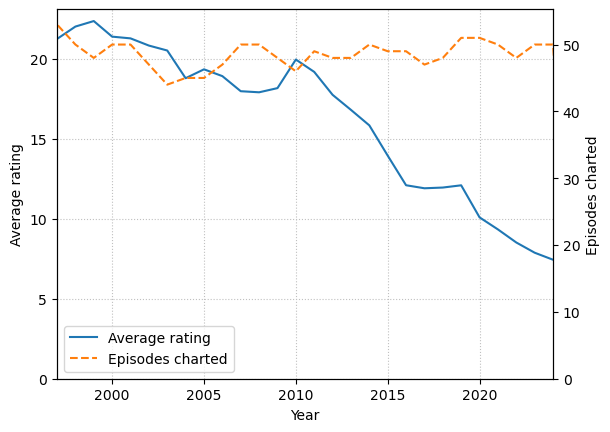

In [129]:
import matplotlib.pyplot as plt

def with_year_index(df: pd.DataFrame):
    idx = df.index
    assert isinstance(idx, pd.DatetimeIndex)
    df.index = idx.year.set_names('Year')
    return df

def avg_rating_by_year(selector: pd.Series):
    by_year = translated_df.loc[selector].groupby(
        pd.Grouper(key='Date', freq='YS'))

    summary = pd.DataFrame({
        'Average rating': by_year['Average Household Rating'].mean(),
        'Episodes charted': by_year.size(),
    })

    return with_year_index(summary)

# The first full year in our dataset is 1997, and the last is most likely the
# previous year. For most graphs, this will be the useful range.
full_years = (1997, date.today().year - 1)

def default_graph(table: pd.DataFrame):
    x = table.index
    y1, y2 = 'Average rating', 'Episodes charted'

    fig, ax = plt.subplots()
    ax.set_ylabel(y1)
    l1, = ax.plot(x, table[y1], linestyle='solid', color='tab:blue', label=y1)
    ax.set_ylim(bottom=0)

    ax2 = ax.twinx()
    ax2.set_ylabel(y2)
    l2, = ax2.plot(x, table[y2], linestyle='dashed', color='tab:orange', label=y2)
    ax2.set_ylim(bottom=0)

    ax.grid(color='#c0c0c0', linestyle='dotted')
    ax.set_xlabel('Year')
    ax.set_xlim(full_years)
    ax.legend([l1, l2], [y1, y2], loc='lower left')
    return fig, ax

fig, ax = default_graph(
    avg_rating_by_year(translated_df['Title'].str.contains('Sazae'))
)

It still usually tops the charts, of course, because the phenomenon is far from unique to Sazae-san. As in most countries, live TV viewership has declined over time in Japan, as people move to time-shifting, streaming, and other forms of entertainment altogether. We can see this trend more broadly in the anime charts by looking at what numbers are required to break into the *bottom* of the chart on the average week of each year:

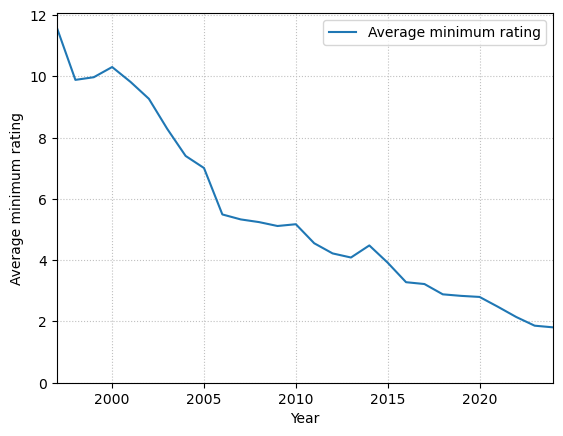

In [130]:
ratings_by_week = by_week(translated_df)['Average Household Rating']
bottom_ratings = ratings_by_week.min().to_timestamp()
year_grouper = pd.Grouper(freq='YS')
avg_min_by_year = with_year_index(pd.DataFrame({
    'Average minimum rating': bottom_ratings.groupby(year_grouper).mean(),
}))

ax = avg_min_by_year.plot(ylabel='Average minimum rating')
ax.set_xlim(full_years)
ax.set_ylim(bottom=0)
ax.grid(color='#c0c0c0', linestyle='dotted')

We can also look at another long-running series like One Piece:

(1999.0, 2024.0)

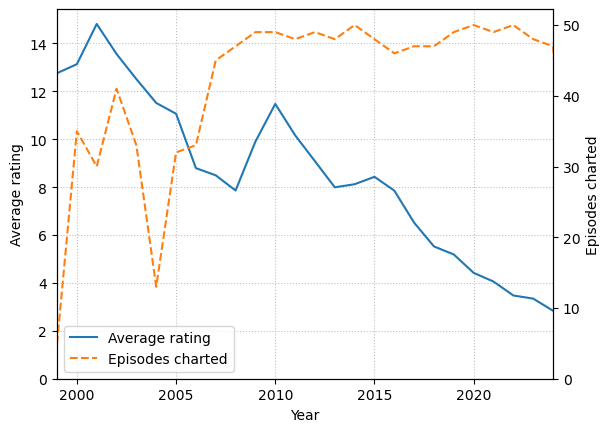

In [131]:
fig, ax = default_graph(
    avg_rating_by_year(translated_df['Title'] == "One Piece")
)
ax.set_xlim(left=1999) # The year One Piece started airing

Or, with a little more work, comparing each Pretty Cure series, which I'll label with the year it started in (generally in February).

In [132]:
def normalize_precure_titles(t: pd.Series):
    # Remove parenthetical notes like (first episode) and (final episode)
    t = t.str.replace(r" \(.*?\)$", '', regex=True)

    # Two cases where such notes appear without parentheses
    t = t.str.replace(r" Fi\w+ Episode$", '', regex=True)
    return t

# Omit six reruns from when production was delayed due to COVID-19.
# These are listed as "Healin' Good Precure Osarai Selection".
precure_rows = translated_df.loc[
    translated_df['Title'].str.contains(r"Pre.+ure")
    & ~translated_df['Title'].str.endswith("Osarai Selection")
].copy()

precure_rows['Title'] = normalize_precure_titles(precure_rows['Title'])
precure_by_title = precure_rows.groupby('Title')
precure_summary = pd.DataFrame({
    'Year': precure_by_title['Date'].min().dt.year,
    'Average rating': precure_by_title['Average Household Rating'].mean(),
    'Episodes charted': precure_by_title.size(),
}).reset_index().set_index('Year').sort_index()
precure_summary

,Title,Average rating,Episodes charted
Year,,,
2004,Futari wa Pretty Cure,7.622222,27
2005,Futari wa Pretty Cure Max Heart,8.075000,40
2006,Futari wa Pretty Cure Splash Star,6.630233,43
2007,Yes! Precure 5,6.634783,46
2008,Yes! Precure 5 GoGo!,5.772973,37
2009,Fresh Precure!,6.572917,48
2010,Heartcatch Precure!,6.637778,45
2011,Suite Precure,5.276190,42
2012,Smile Precure!,5.354348,46


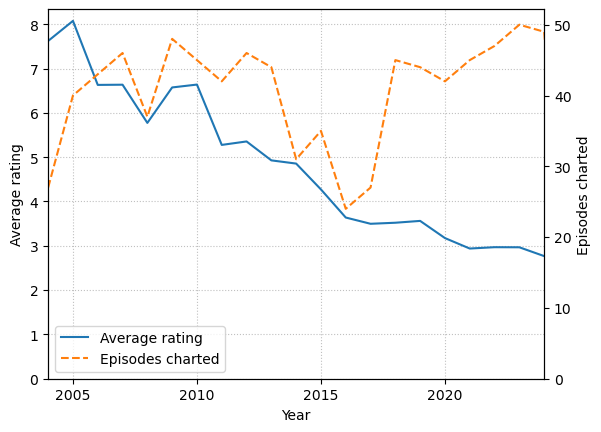

In [133]:
fig, ax = default_graph(precure_summary)
ax.set_xlim(2004, precure_summary.index.max() - 1)
# From Futari wa Pretty Cure to the latest completed series.
ax.xaxis.get_major_locator().set_params(integer=True)

This may be related to the phenomenon of late-night anime making the charts more often; they could be more resistant to the trends that have driven viewership down. It's likely not the only cause, however -- the wild success of Demon Slayer makes it clear that late-night anime is simply far more mainstream than it once was. The likes of Spy x Family and Jujutsu Kaisen have regularly ranked among Japan's best-selling manga, and were recognized early on as potential major hits, yet their anime adaptations aired late at night, and to great success.

But the rise of late-night anime is not the only major shift in the top anime broadcasts. To get the big picture, we'll need some more sophisticated visualizations. Let's use a couple of heatmaps to take a look at how the most common times and days of the week have shifted over the years.

In [134]:
import seaborn as sns

weekday_order = ['Monday', 'Tuesday', 'Wednesday',
                 'Thursday', 'Friday', 'Saturday', 'Sunday']
next_weekday = {d:weekday_order[(i+1) % 7] for i, d in enumerate(weekday_order)}

def year_times(df: pd.DataFrame):
    y = df['Date'].dt.year
    d = df['Date'].dt.day_name()
    h, m = split_time(df['Time'])

    # If minute is 50 or later, round hour up. If this makes the hour midnight,
    # round day of week up.
    round_hour = m >= 50
    round_day = round_hour & (h == 23)
    h = h.mask(round_hour, (h + 1) % 24)
    d = d.mask(round_day, d.replace(next_weekday)).astype('category')

    return pd.DataFrame({'Year': y, 'Hour': h, 'Weekday': d,})

year_times_df = year_times(translated_df)

def heat_map(col1: str, col2: str):
    table = year_times_df[[col1, col2]].value_counts().unstack(fill_value=0)

    if col1 == 'Year':
        table = table.loc[slice(*full_years)]
    if col2 == 'Weekday':
        table = table[weekday_order]
    
    return table

def styled_heat_map(col1: str, col2: str):
    cm = sns.color_palette("rocket", as_cmap=True)
    return heat_map(col1, col2).style.background_gradient(cmap=cm, axis=None)

styled_heat_map('Year', 'Hour')

Hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Year,,,,,,,,,,,,,,,,,,,,,,,,
1997,0,0,0,0,0,0,0,0,8,44,2,0,0,0,0,0,2,16,152,295,0,2,0,0
1998,0,0,0,0,0,0,0,3,26,40,2,0,0,0,1,0,4,15,121,315,0,2,0,0
1999,0,0,0,0,0,0,0,2,34,38,2,0,0,0,0,1,3,6,114,320,0,2,0,0
2000,0,0,0,0,0,0,0,0,38,33,6,0,0,0,0,0,3,4,118,327,0,1,0,0
2001,0,0,0,0,0,0,0,1,34,26,9,0,0,0,0,1,0,1,138,315,0,2,0,0
2002,0,0,0,0,0,0,0,1,20,14,5,0,0,0,0,0,1,1,116,369,0,1,0,0
2003,0,0,0,0,0,0,0,0,19,38,0,0,0,0,0,0,0,3,105,356,3,2,0,0
2004,1,1,0,0,0,0,0,1,29,53,2,0,1,0,0,0,1,1,101,341,1,1,0,0
2005,1,0,0,0,0,0,0,0,39,38,2,0,0,0,0,1,3,2,109,325,2,1,0,0


In [135]:
styled_heat_map('Year', 'Weekday')

Weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Year,,,,,,,
1997,85,38,68,4,100,26,200
1998,91,22,49,44,95,6,222
1999,92,14,46,52,108,6,204
2000,89,21,45,47,95,9,224
2001,92,23,29,37,112,8,226
2002,82,13,74,23,94,30,212
2003,86,7,35,34,97,60,207
2004,82,19,56,12,89,35,241
2005,89,17,77,15,82,8,235


Here, the arguably starkest change in the top live anime broadcasts becomes apparent: a massive shift away from weekdays, largely in the early evening, and toward Saturdays in the morning and late afternoon. Partly, this reflects timeslot changes for some major programs that had aired between 7:00 and 8:00 PM:

* In 2001, Fuji TV moved One Piece from its original Wednesday 7:00 PM slot to Sunday 7:30 PM. The original slot had been broadcasting anime since 1965 with only a half-year break in 1969-70; most recently, it had hosted 18 years of anime based on Akira Toriyama's manga Dr. Slump and Dragon Ball. At the start of 2005, it was moved half an hour earlier, then in 2006 to 9:30 AM. This last move ended a block that had broadcast anime without interruption since Mazinger Z in 1972, usually for a full hour.
* In 2009, Nippon TV moved Detective Conan from Monday 7:00 PM to Saturday 6:00 PM. Other shows in the old timeslot had also charted regularly, including The Kindaichi Case Files, Inuyasha, and Black Jack.
* In 2019, TV Asahi moved Doraemon and Crayon Shin-chan from Friday 7:00-8:00 PM to Saturday 4:30-5:30 PM, switching their order in the process to put Shin-chan first. Doraemon had aired in its previous slot since 1981, and that slot had been airing anime continuously since 1973, including such titles as Aim for the Ace!, Yuusha Raideen, and Candy Candy.

(These changes are not reflected in most English-language anime sites. As of this writing, for instance, the broadcast information on [MyAnimeList's page for One Piece](https://myanimelist.net/anime/21/One_Piece) simply reads "Sundays at 09:30 (JST)". [Doraemon's page](https://myanimelist.net/anime/8687/Doraemon_2005) is not just incomplete but outdated, reading "Fridays at 19:00 (JST)", several years after it changed.)

But in many cases, when one primetime anime ended, it simply wasn't replaced with another. Furthermore, the programs that changed timeslots often replaced a previously-airing anime, with no new anime in the old timeslot, leaving one less anime timeslot overall. Declining birth rates have simply meant even family-friendly anime is no longer worth a weekday primetime slot.

This is especially apparent in TV Tokyo's lineup. In the early 2000s, the bulk of TV Tokyo's weekday lineup from 6:00 to 8:00 PM would be composed of anime, with as many as 14 series airing new episodes at a time in those blocks. Even by the end of the decade, this number had declined, and now, Pokémon is nearly their only early-evening series. We can see how their presence in the rankings has been reduced even if we don't consider timeslots:

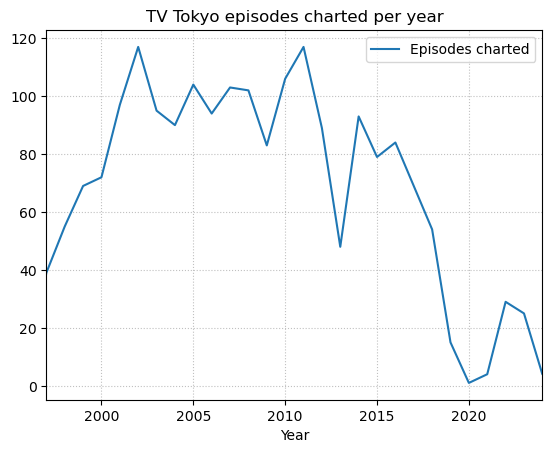

In [136]:
tv_tokyo_avg = avg_rating_by_year(translated_df['Station'] == "TV Tokyo")

ax = tv_tokyo_avg.plot(
    y='Episodes charted',
    title="TV Tokyo episodes charted per year",
    xlim=full_years,
)
ax.grid(color='#c0c0c0', linestyle='dotted')

A few other trends can be seen in the heatmaps, if you know what to look for:

* The rise of late-night anime, mainly represented here by Demon Slayer and NTV's [Friday Anime Night](https://en.wikipedia.org/wiki/Friday_Anime_Night) block, which benefits greatly from airing after Friday Road Show.
* The success of Yomiuri TV's 5:30 PM Saturday block, discussed above.
* A sharp decline (even relative to other anime) in the success of Fuji TV's 9:00 AM Sunday block, also discussed above, starting in 2020 -- evidently, the Digimon Adventure reboot and Digimon Ghost Game didn't perform nearly as well as their predecessors, nor can the current title Run for Money: The Great Mission compare to Toriko, GeGeGe no Kitarō, or Dragon Ball Kai and Super.

It's arguable that there's also been a trend toward less variation in the titles appearing on any given year's chart. One popular tool for measuring diversity is the Shannon index, based on measurements of entropy. If we use it to measure diversity of titles after grouping by year, we can see a slight but measurable decrease. This is shown in the graph below, with a trend line included in red.

Text(1, 1, '$R^2$ = 0.254')

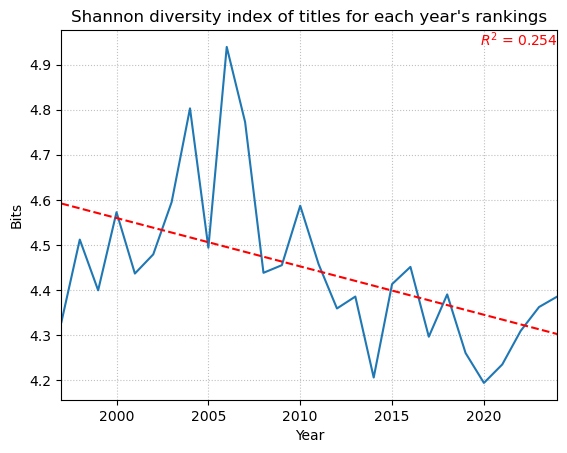

In [137]:
import numpy as np
from numpy.polynomial import Polynomial

def title_shannon_index(df: pd.DataFrame) -> int:
    p = df['Title'].value_counts(normalize=True)
    return -np.sum(p * np.log2(p))

def r_squared(y, predicted):
    ss = lambda a: np.sum((a - y)**2)
    return 1 - ss(predicted) / ss(np.mean(y))

gb = pd.DataFrame({
    'Year': translated_df['Date'].dt.year,
    'Title': translated_df['Title']
}).groupby('Year')

entropy = gb.apply(title_shannon_index, include_groups=False)
entropy = entropy.loc[slice(*full_years)]

x = entropy.index
trend = Polynomial.fit(x, entropy, 1)(x)

ax = entropy.plot(
    title="Shannon diversity index of titles for each year's rankings",
    xlim=full_years,
)
ax.set_ylabel("Bits")

ax.plot(x, trend, linestyle='dashed', color='red')
ax.grid(color='#c0c0c0', linestyle='dotted')
ax.annotate(
    text=f"$R^2$ = {r_squared(entropy, trend):.3f}", c='red',
    xy=(1,1), ha='right', va='top', xycoords='axes fraction'
)

Thus far we have focused on the household ratings, because they are present throughout the dataset, but it may be worthwhile to examine the figures for individual ratings kept since 2020.

The individual rating is by definition less than the household rating, because not everyone in every household will be watching a broadcast. Naturally, though, they are strongly correlated.

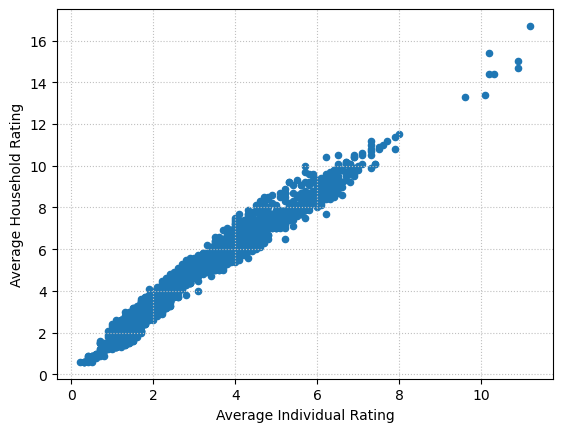

In [138]:
with_individual = translated_df.loc[
    translated_df['Average Individual Rating'].notna()
].copy()

ax = with_individual.plot.scatter('Average Individual Rating',
                                 'Average Household Rating')
ax.grid(color='#c0c0c0', linestyle='dotted')

(The top-right outliers are all broadcasts of Demon Slayer specials over two hours, aired at 7:00 PM or 9:00 PM.)

The ratio between the two -- the average proportion of people watching in households that are watching -- is not constant, and its variation is of interest. As it turns out, there has been a distinct increase in this ratio over time:

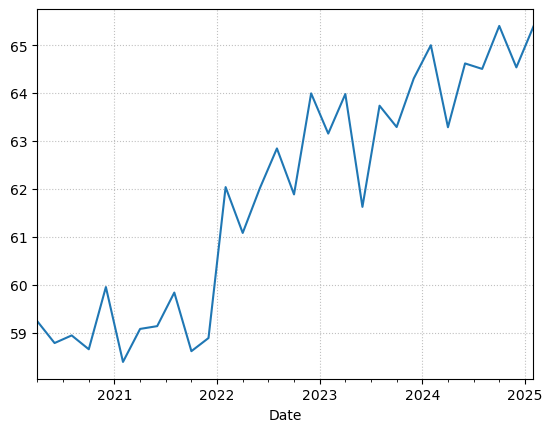

In [139]:
air = with_individual['Average Individual Rating']
ahr = with_individual['Average Household Rating']
with_individual['Individual/Household Ratio (%)'] = 100 * air / ahr

ax = group_2m(with_individual)['Individual/Household Ratio (%)'].mean().plot()
ax.grid(color='#c0c0c0', linestyle='dotted')

This may be due to decreases in the average household size over time. If 1.5 people are watching on average, and there are 2.37 people per household on average, the ratio is 63%; if the average household size drops to 2.23, the ratio increases to 67%. Numbers for average household size for each year could help verify this.

There are also variations by program when controlling for the year:

In [140]:
def minute_of_30h_day(t: pd.Series):
    h, m = split_time(t)
    h = h.mask(h < 6, h + 24) # So, e.g., 23:55 and 0:05 stay close together.
    return h*60 + m

def typical_time(t: pd.Series):
    mode = t.astype(str).mode()
    if len(mode) == 1:
        return mode[0]
    else:
        modes = mode.sort_values(key=minute_of_30h_day)
        return f"{modes.iloc[0]}-{modes.iloc[-1]}"

wi_year = with_individual['Date'].dt.year

for y in sorted(wi_year.unique().tolist()):
    filtered = with_individual.loc[
        wi_year == y
    ].groupby('Title').filter(lambda x: len(x) >= 3)
    
    means = filtered.groupby('Title').agg({
        'Individual/Household Ratio (%)': 'mean',
        'Time': typical_time,
    })

    print(y)
    display(means.sort_values(by='Individual/Household Ratio (%)'))

2020


,Individual/Household Ratio (%),Time
Title,,
Soreike! Anpanman,49.073042,10:55
Yashahime: Princess Half-Demon,52.622998,17:30
Hakushon Daimaō 2020,53.875264,17:30
GeGeGe no Kitarō,54.535942,9:00
One Piece,54.702799,9:30
Crayon Shin-chan,54.796351,16:30
Detective Conan,57.867341,18:00
Healin' Good Precure Osarai Selection,58.235378,8:30
Doraemon,59.282139,17:00


2021


,Individual/Household Ratio (%),Time
Title,,
Attack on Titan The Final Season,46.199430,0:10
Edens Zero,48.222222,0:55-2:00
Soreike! Anpanman,49.333427,10:55
Lupin the 3rd Part 6,50.052475,0:55
Digimon Adventure:,51.302001,9:00
My Hero Academia,52.428476,17:30
Yashahime: Princess Half-Demon,53.670560,17:30
One Piece,55.420820,9:30
Crayon Shin-chan,55.458805,16:30


2022


,Individual/Household Ratio (%),Time
Title,,
Soreike! Anpanman,49.578267,10:55
Lupin the 3rd Part 6,49.784599,0:55
Mobile Suit Gundam: The Witch From Mercury,51.801075,17:00
Jujutsu Kaisen: Kyoto Sister School Goodwill Event Arc,53.782886,17:00
Jujutsu Kaisen Cursed Womb Arc,53.816739,17:00
Love All Play,54.015055,17:30
Yashahime: Princess Half-Demon,54.407145,17:30
My Hero Academia,54.985562,17:30
One Piece,57.309850,9:30


2023


,Individual/Household Ratio (%),Time
Title,,
Jujutsu Kaisen season 2,52.480951,23:56
Mobile Suit Gundam: The Witch from Mercury,52.693140,17:00
MIX Season 2,55.496852,17:30
My Hero Academia,56.280130,17:30
Firefighter Daigo: Rescuer in Orange,56.282164,17:30
Frieren: Beyond Journey's End,56.334903,23:00
Soreike! Anpanman,56.727994,10:55
One Piece,56.738406,9:30
Spy×Family,57.832799,23:00


2024


,Individual/Household Ratio (%),Time
Title,,
The Apothecary Diaries,50.771605,0:55
Kinnikuman: Perfect Origin Arc,52.391304,23:30-23:55
Dragon Ball Daima,54.272405,23:40
Firefighter Daigo: Rescuer in Orange,55.356628,17:30
Blue Miburo,55.550357,17:30
That Time I Got Reincarnated as a Slime season 3,55.718385,23:00
My Hero Academia,56.005085,17:30
Frieren: Beyond Journey's End,56.828522,23:00
Demon Slayer: Kimetsu no Yaiba Hashira Training Arc,57.250083,23:15


2025


,Individual/Household Ratio (%),Time
Title,,
The Apothecary Diaries,54.240761,23:30
Blue Miburo,56.649168,17:30
Dragon Ball Daima,57.363316,23:40
One Piece,59.797821,9:30
Crayon Shin-chan,60.077068,16:30
Detective Conan,61.414028,18:00
You and Idol Precure♪,64.907053,8:30
Doraemon,65.007782,17:00
Wonderful Precure!,65.654321,8:30


Late-night programs tend to have low ratios, because usually only one person will be staying up late to watch. Those aren't the only ones, though. The programs airing immediately before Detective Conan consistently have low ratios; Anpanman and Gundam: The Witch from Mercury have often had even lower ones. Pretty Cure consistently has high ratios, but not as high as Pokémon Horizons, Sazae-san, or the E-Tele Kids shows. Not all of these variations are easily explained, and much remains to be understood.

# Next steps

A number of improvements to this analysis are possible:

- Separating web client and caching into a separate class, and adding support for caching DataFrames in addition to raw response data.
- Improving existing visuals to increase clarity, such as changing cell 138's scatter plot to a `plt.hist2d()`, or using `sns.heatmap()` for the heatmaps.
- Adding visuals such as an animated heat map showing change over time in the top anime's distribution across the weekly schedule.
- Possibly replacing the categorical `Time` columns with a pair of integers `H` and `M`.

I hope this analysis has proven of interest, and that it will lead to further research -- as well as improved fan understanding of the works they love, and the systems that produce them.